In [80]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict, Counter

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

import pickle

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


# from google.colab import drive
# drive.mount('/content/gdrive')
import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
from NN_utils import BigTable, WeightClip

def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = numpy.exp(diffs)/(1.0+ numpy.exp(diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def calc_probs(s,q):
    zmask = numpy.isclose(q,-10).astype(int)
    diff = s-q
    prs = 1.0/(1.0+ numpy.exp(-diff))
    prs = numpy.maximum(zmask,prs)
    # print(prs)
    if len(q.shape)>1 and len(q.shape[0]) > 1:
      raise Exception("tensor is wrong shape, duh")
      # pr = pr.reshape(len(q))
    pr = numpy.prod(prs)
    return pr, zmask

# home = "/content/gdrive/My Drive/Colab Notebooks"
home="."

import pandas
mapping = pandas.read_csv(home+"/real_data/qn_act_map.csv")
mapping.index = mapping.qn_id
# mapping.drop("qn_id", axis=1, inplace=True)
print(mapping[0:100])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
started
                                     qn_id     activity_name  \
qn_id                                                          
Dialogue 1~1.0              Dialogue 1~1.0        Dialogue 1   
Dialogue 1~2.0              Dialogue 1~2.0        Dialogue 1   
Dialogue 1~3.0              Dialogue 1~3.0        Dialogue 1   
Dialogue 1~4.0              Dialogue 1~4.0        Dialogue 1   
Dialogue 1~5.0              Dialogue 1~5.0        Dialogue 1   
Minimal pairs 1~1.0    Minimal pairs 1~1.0   Minimal pairs 1   
Minimal pairs 1~2.0    Minimal pairs 1~2.0   Minimal pairs 1   
Minimal pairs 1~3.0    Minimal pairs 1~3.0   Minimal pairs 1   
Minimal pairs 1~4.0    Minimal pairs 1~4.0   Minimal pairs 1   
Minimal pairs 1~5.0    Minimal pairs 1~5.0   Minimal pairs 1   
Minimal pairs 1~6.0    Minimal pairs 1~6.0   Minimal pairs 1   
Minimal pairs 1~7.0    Minimal pairs 1~7.0   Minimal pairs 1   
Minimal 

In [81]:
# def create_databundle():
# if True:
#     raw_df = pandas.read_csv(home+"/real_data/Worksheet_1041.csv")
#     print(raw_df.columns)
#     print(len(raw_df))
#     raw_df = raw_df[raw_df.event_type=="answer_submitted"]
#     print(len(raw_df))


In [82]:
def progress_one_step(q,s, s_gammas):
  pr, zmask = calc_probs(s,q)
  active_in_q = 1-zmask
  # print(active_in_q)
  # print("pr is", pr)
  passed = 0
  if (numpy.random.random() <= pr):
    passed = 1
  s= s + s_gammas*active_in_q # learning rates from a successful attempt
  # else:
  #   s= s + s_rhos*active_in_q # learning rates from an unsauccessful attempt
  return passed, pr, s

In [83]:
def run_data(students, questions, gammas, model_to_train=None):
  from collections import defaultdict, Counter
  sixs = []
  qixs = []
  hits = []
  outps = []
  
  r = -1
  scores = defaultdict(int)
  hit_counter = {}
  
  s_indices = range(len(students))
  # bo_selecta = None
  for six in s_indices:
    print("running student, ", six)
    s = students[six]
    R = 0  # reset reward for new student
    ball_bag = list(range(len(questions)))
    while ball_bag:
      # print("WSH",s.shape)
      # print(numpy.mean(s), numpy.min(s), numpy.max(s))
      # for sval in s:
      #   print(sval)
      # raise Exception("WANK")
      # if bo_selecta is None:
      bo_selecta = random.choice(ball_bag)
      q = questions[bo_selecta]
      passed, pr, s_ = progress_one_step(q,s, gammas[six])
      students[six] = s_ # Crucially, update the student to make progress...
      # print(six, bo_selecta, numpy.mean(students[six]), pr)
      if passed:
        # print("***PASSED***", six, bo_selecta, pr)
        ball_bag.remove(bo_selecta)

      # hit_counter[(six, bo_selecta)] += 1
      # hit_counter
    
      if six not in hit_counter:
        print("INIT'G zeros FOR", six)
        hit_counter[six] = [int(0)]*n_questions #numpy.zeros(n_questions, dtype="uint8")

      sixs.append( [int(six)])
      qixs.append([int(bo_selecta)])
      hits.append( tuple(hit_counter[six]) )
      outps.append( [int(passed)] )

      # neue = hit_counter[six]
      # neue[bo_selecta] += 1
      hit_counter[six][bo_selecta] += 1

      R += r
      # bo_selecta = None
    print(R)
    scores[six] = R

  # if model_to_train:
  #   phat = model_to_train.predict([[six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ])
  #   mae = abs(pr - phat)
  #   print(pr, phat, mae)
  #   model_to_train.train_on_batch( [ [six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ], [passed] )
 
  # print("Die Arrays werden in Numpy Datentypen verwandelt.")
  # sixs = numpy.array(sixs, dtype="uint8")
  # qixs = numpy.array(qixs, dtype="uint8")
  # hits = numpy.array(hits, dtype="uint8")
  # outps = numpy.array(outps, dtype="uint8")

  # print(hits.shape)
  # print(outps.shape)

  # if model_to_train:
    # phat = model_to_train.predict([[six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ])
    # mae = abs(pr - phat)
    # print(pr, phat, mae)
    # model_to_train.fit( inps, outps )
  # for (k,v) in scores.items():
  #   print(k,v)
  print("Der Lauf is beendet.")
  vals = list(scores.values())
  return numpy.mean(vals), sixs, qixs, hits, outps


In [84]:
from keras.regularizers import l1
from keras.layers import Reshape, Dense, Dropout, add, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, concatenate, Flatten, Maximum, Multiply, dot, Layer
from keras import backend as K, Model
from keras.initializers import RandomUniform, RandomNormal

def hard_sigmoid(x):
    return np.maximum(0, np.minimum(1, (x + 2) / 4))

def binary_regulariser(x):
    return K.sum( 1.0-(4.0*K.pow((0.5 - x),2)) )
    # return K.sum(K.log(2*x) +K.log(2*(1-x)))
    # return K.log(2*x) +K.log(2*(1-x))
    
from keras import backend as K
def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
    true_positives = K.sum(y_true * y_pred) + K.epsilon()
    possible_positives = K.sum(y_true) + K.epsilon()
    recall = true_positives / possible_positives
    return recall

def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
    true_positives = K.sum(y_true * y_pred) + K.epsilon()
    predicted_positives = K.sum(y_pred) + K.epsilon()
    precision = true_positives / predicted_positives
    return precision

def f1_metric(y_true, y_pred, average="macro"):
    y_true = K.cast(y_true, "float32")
    precision_1 = precision_m(y_true, y_pred)
    recall_1 = recall_m(y_true, y_pred)
#     print("p/r 1", K.eval(precision_1), K.eval(recall_1))
    f1_1 = 2.0*precision_1*recall_1 / (precision_1+recall_1)
#     print("f1_1", K.eval(f1_1))
    if average=="macro":
        precision_0 = precision_m((1-y_true), (1-y_pred))
        recall_0 = recall_m((1-y_true), (1-y_pred))
#         print("p/r 0", K.eval(precision_0), K.eval(recall_0))
        f1_0 = 2.0*precision_0*recall_0 / (precision_0+recall_0)
#         print("f1_0", K.eval(f1_0))
        f1 = (f1_1+f1_0)/2.0
#         print("f1  ", K.eval(f1))
        return f1
    else:
        return f1_1

def f1_loss(y_true, y_pred, average="macro"):
    return (1.0 - f1_metric(y_true, y_pred, average=average))
    

In [85]:
#5e-5/row_w
def generate_MLTM_raw_model(n_questions, n_students, row_w, ptqs=None, 
                        loss="binary_crossentropy",
                        metrics=None, init50=True, deep_HEU=False, reg=None, reg_w=None,
                        pos_only=False):
    print("MLTM RAW:\nROW W is ", row_w)
    print("reg is",reg)
    print(n_questions, n_students)

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.regularizers import L2
    from keras.constraints import NonNeg
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)
#     long_clip = WeightClip(-math.inf, math.inf)
#     long_clip = WeightClip(-5,5+sp)
#     if pos_only:
#     long_clip = WeightClip(0, 6+2*sp)

#     q_init = RandomNormal(mean=sp) if init50 else "uniform"
#     q_init = RandomNormal(mean=-sp) if init50 else "uniform"
    q_init = RandomUniform(minval=sp-0.5, maxval=sp+0.5) if init50 else "uniform"
#     q_init = "uniform"

    if reg_w is None:
        reg_w = 0
        
    reg_pen = 0.001/(((2*(1 if sp==0 else sp))**2)*(n_students*row_w))
    print("reg_pen is", reg_pen)
    
    qn_emb = Embedding(n_questions, row_w, 
#                        embeddings_regularizer=L2(100.0/(n_questions*row_w)**2) if "l1" in reg else None, 
#                        embeddings_regularizer=L2( reg_pen ),
                       embeddings_initializer=q_init,
                       name="qn_embedding")
#     qn_row = Flatten()(long_clip(qn_emb(qn_sel)))
    qn_row = Flatten()(qn_emb(qn_sel))
#     qn_row = Dense(row_w)(qn_row)
    
#     if reg_w is None:
#         this_w = 32e-8
#     else:
#         this_w = (reg_w/row_w)
    #embeddings_initializer=RandomNormal(mean=1+sp)
    s_init = RandomNormal(mean=2*sp) if init50 else "uniform"
#     s_init = "uniform"
#     pos_clip = WeightClip(0, math.inf)
#     gamma_row = Flatten()(NonNeg()(Embedding(n_students, row_w, name="gammas")(psi_sel)))
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    
    alpha_row = Flatten()(Embedding(n_students, row_w, 
                                                embeddings_initializer=s_init, 
#                                                 embeddings_regularizer=L2(200.0/(n_students*row_w)**2) if "l2" in reg else None, 
                                                embeddings_regularizer=L2( reg_pen ),
                                                name="alphas")(psi_sel))
#     alpha_row = Dense(row_w)(alpha_row)
#     if reg:
#         alpha_row = tensorflow.keras.layers.ActivityRegularization(l2=0.01/row_w)(alpha_row)
  
    kc_practice = Dense(row_w, use_bias=True, name="qk_loadings")(hit_counter)
#     kc_practice = Dense(row_w, use_bias=False, kernel_constraint=NonNeg(), name="qk_loadings",)(hit_counter)
#     kc_practice = Lambda(lambda x: K.log(x+1e-6))(kc_practice)
#     kc_practice = Dense(row_w, kernel_constraint=NonNeg())(kc_practice)
#     kc_practice = tensorflow.keras.layers.ActivityRegularization(l1=0.00001/row_w)(kc_practice)
    
#     psi_row = long_clip( add( [alpha_row, multiply([kc_practice, gamma_row])]) )
#     psi_row = Dense(row_w, activation="linear")(psi_row)

    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])
#     psi_row = alpha_row
    difs = subtract([psi_row, qn_row], name="difs")
#     difs = tensorflow.keras.layers.ActivityRegularization(l2=0.001/row_w)(difs)
#     difs = Dense(row_w, activity_regularizer=L2(0.1/row_w))(difs)

    Prs = Lambda(lambda z: K.sigmoid(z))(difs)
    
#     logs = Lambda(lambda ps: K.log(ps), name="log_step")(Prs)
#     summed_logs = Lambda(lambda ps: K.sum(ps, axis=-1, keepdims=True), name="sum_step")(logs)
#     score = Lambda(lambda ps: K.exp(ps), name="exp_step")(summed_logs)

    score = Lambda(lambda prs: K.prod(prs, axis=-1, keepdims=True))(Prs)
#     score = Lambda(lambda prs: tensorflow.math.reduce_logsumexp(prs, axis=-1, keepdims=True))(Prs)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [86]:
def generate_MLTM0_model(n_questions, n_students, row_w, 
                        loss="binary_crossentropy",
                        metrics=None,
                        l2=False):
    print("ROW W is ", row_w)
    # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.regularizers import L1,L2
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)
    pos_clip = WeightClip(0.0000, 100)
#     bin_clip = WeightClip(0.0000, 1.0000)

    base = 1
    q_init = RandomNormal(mean=base)
    qn_emb = Embedding(n_questions, row_w, embeddings_initializer=q_init, 
#                        activity_regularizer=L1(1/row_w), 
                       name="qn_embedding")
    qn_row = Flatten(name="qn_row_out")(pos_clip(qn_emb(qn_sel)))
    
# Q MAsking STilL reQuired
    k=1000
    qmask = Lambda(lambda x: K.clip(x*k,0.0000,1.0000))(qn_row)
    
    
    w2 = 32e-8/row_w
    print("using penalty", w2)
    alpha_row = Embedding(n_students, row_w, 
                          embeddings_initializer=RandomNormal(mean=base+sp), name="alphas",
                          embeddings_regularizer=L2(w2),
                          )(psi_sel)
    gamma_row = Embedding(n_students, row_w, name="gammas")(psi_sel)
    alpha_row = Flatten()(alpha_row)
    gamma_row = Flatten()(gamma_row)

    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])], name="psi_row_out")

    difs = subtract([psi_row, qn_row], name="difs")
    Prs = Lambda(lambda z: K.sigmoid(z))(difs)
    Prs = Lambda(lambda x: K.pow(x[0],K.abs(x[1])) )([Prs, qmask])

    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True))(Prs)
    
    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [87]:
# def my_regularizer(x):
#     return K.sum(K.square(x), axis=1)

def generate_MLTMb_model(n_questions, n_students, row_w, 
                        loss="binary_crossentropy",
                        metrics=None,
                        reg=None,
                        reg_w = None):
    print("MLTMb model with reg", reg)
    print("ROW W is ", row_w)
    # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.regularizers import L1,L2
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0.0000, 1.0000)
#     lam_clip = Lambda(lambda x: K.clip(x,0.0000,1.0000))
#     long_clip = WeightClip(-100,100)
    
    etas = Embedding(1, row_w, input_length=1, 
                     embeddings_initializer=RandomNormal(0),
                     name="skill_diffs")
    
    l2_w = reg_w if (reg_w is not None) else 1.5e-06
    effs = Embedding(n_questions, row_w, 
#                      embeddings_constraint=WeightClip(0, 1), 
                     embeddings_initializer=RandomUniform(0.999,1), 
                     name="qn_embedding",
#                      embeddings_initializer = RandomNormal(1),
#                      embeddings_regularizer=L2(10000.0/(n_questions*row_w)**2) if reg=="l1" else None,
#                      embeddings_regularizer=L1(l2_w/(n_questions*row_w)) #if reg=="l1" else None,
                        activity_regularizer=L1(1.55e-06) #if reg=="l1" else None,
                     )
    
#     effs = Embedding(n_questions, row_w, name="qn_embedding")

#     qn_row = Flatten(name="qn_row_out")(long_clip(etas(zer0(qn_sel))))
    qn_row = Flatten(name="qn_row_out")(etas(zer0(qn_sel)))

#     delta_loading_is_qmask = Flatten(name="qmask_out")(lam_clip(bin_clip(effs(qn_sel))))
#     delta_loading_is_qmask = Flatten()(effs(qn_sel))
    delta_loading_is_qmask = Flatten(name="qmask_out")(bin_clip(effs(qn_sel)))

# Q MAsking STilL reQuired
    
    w2 = 32*1.5e-6 / row_w
    print("l2 penalty is", w2)
    alpha_row = Embedding(n_students, row_w, 
                          embeddings_initializer=RandomNormal(sp), name="alphas",
#                           embeddings_regularizer=L2(l2_w/(n_students*row_w)**2) if reg=="l2" else None,
#                           embeddings_regularizer=L2(l2_w) if reg=="l2" else None,
#                           embeddings_regularizer=L2(0.01) if reg=="l2" else None,
#                             embeddings_regularizer=L2(w2)
                         )(psi_sel)
    gamma_row = Embedding(n_students, row_w, name="gammas", 
                          embeddings_initializer=RandomNormal(0),
                         )(psi_sel)
    alpha_row = Flatten()(alpha_row)
    gamma_row = Flatten()(gamma_row)

    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])], name="psi_row_out")

    difs = subtract([psi_row, qn_row], name="difs")
    Prs = Lambda(lambda z: K.sigmoid(z))(difs)
    Prs = Lambda(lambda x: K.pow(x[0],K.abs(x[1])) )([Prs, delta_loading_is_qmask])
    
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True))(Prs)
    
    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [88]:
def create_CFM_model(n_questions, n_students, row_w, loss="binary_crossentropy", 
                     sfocus=False, metrics=None, reg=None, reg_w=None):
    print("Using CFM model!")

    print("ROW W is ", row_w)
    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.regularizers import L1, L2
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0.0000, 1.0000)
#     bin_clip = Lambda(lambda c: K.clip(c,0,1))
    
    reg_w = 0 if reg_w is None else reg_w
    
    sp = pr_to_spread(.5, row_w, as_A_and_D=False)
    B = Embedding(1 , row_w, name="skill_diffs", embeddings_initializer=RandomNormal(0, stddev=0.1))
    theta_i = Flatten()(Embedding(n_students, 1, name="alphas", 
                                  embeddings_initializer=RandomNormal(sp, stddev=0.1),
#                                   embeddings_regularizer=L2(10),
                                  embeddings_regularizer= L2(1.45e-05),# if ("l2" in reg) else None,
#                                   embeddings_regularizer= L2(reg_w) if ("l2" in reg) else None,
#                                   embeddings_regularizer= L2(1),# if ("l2" in reg) else None,
                                 )  (psi_sel))

    print("theta_i shape", theta_i.shape)
    
    Q = Embedding(n_questions, row_w, name="qn_embedding", 
#                        embeddings_constraint=WeightClip(0, 1), 
                         embeddings_initializer=RandomUniform(0.99,1),
#                          embeddings_regularizer = L1(reg_w / (row_w*n_questions) )# if ("l1" in reg) else None,
                 )
        
#     gamma_k = Flatten()(Embedding(1, row_w, name="gammas", embeddings_initializer=RandomNormal(0),)  (zer0(qn_sel)))
    gamma_k = Flatten()(Embedding(1, row_w, name="gammas")  (zer0(qn_sel)))

    beta_k = Flatten()(B( zer0(qn_sel) ))
    q_jk = Flatten()(bin_clip( Q(qn_sel) ))

    print("shape kc-gammas", gamma_k.shape)
    T_jk = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)

    prog = multiply([gamma_k, T_jk])
    
    skill_now = Add()([theta_i, prog])
    logit_difs = subtract([skill_now, beta_k])
    
    print("logit shape", logit_difs.shape)
    Prs = Lambda(lambda z: K.sigmoid(z))(logit_difs)
    
#     Prs = Lambda(lambda mx: K.pow(mx[0],mx[1]))([Prs, q_jk])
    Prs = Lambda(lambda mx: mx[1]*mx[0] + (1-mx[1]) )([Prs, q_jk])
        
    print("Prs shape", Prs.shape)
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True))(Prs)
    
    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    from keras.optimizers import SGD, RMSprop, Nadam, Adam
    #   optr = SGD(learning_rate=1.0)#, momentum=0.01, nesterov=True)
    #   optr = RMSprop()
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)
    return model


In [89]:
def create_AFM_model(n_questions, n_students, row_w, loss="binary_crossentropy", 
                     sfocus=False, metrics=None, reg=None):
    print("Using {}AFM model!".format("S" if sfocus else ""))
    print("reg is", reg)
    
    #AFM
    # p_ij = sig( a_i + sum[k in KC(j)] b_k + g_k*n_ik )
    
    #sAFM
    # p_ij = sig( sum[k in KC(j)] a_ik + b_k + g_k*n_ik )
    
    print("ROW W is ", row_w)
    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.regularizers import L2,L1
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0.0000,1.0000)
    
    skill_d_ws = Embedding(1 , row_w, name="skill_diffs", embeddings_initializer=RandomNormal(0, stddev=0.1))
#   a0 = 5
    qn_mx = Embedding(n_questions , row_w, name="qn_embedding", 
#                        embeddings_constraint=WeightClip(0, 1), 
                       embeddings_initializer=RandomUniform(0.99,1),
#                        activity_regularizer="l1" if ("l1" in reg) else None,
                     )
    
    gamma_row = Embedding(1, row_w, name="gammas",
#                     embeddings_initializer=RandomNormal(0),
                    )(zer0(psi_sel))
    a0 = Embedding(n_students, 1, name="alphas", 
                  embeddings_initializer=RandomNormal(0, stddev=0.1),
                  embeddings_regularizer= L2(1.45e-05) if ("l2" in reg) else None,
                  )(psi_sel)

    etas = Flatten()( skill_d_ws(zer0(qn_sel)) ) 
    
    q_mask = Flatten()( bin_clip(qn_mx(qn_sel)) )

    gamma_row = Flatten()(gamma_row)
    print("shape kc-gammas", gamma_row.shape)
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    print("shape kc-practice", kc_practice.shape)
    prac_modifier = Multiply()([kc_practice, gamma_row])

    difs = subtract([prac_modifier, etas])
    difs = Multiply()([difs, q_mask]) # mask off irrelevant KCs
    
    print("Difs shape", difs.shape)
    summed = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="lambda_sums")(difs)
    print("Summed shape", summed.shape)
    
    a0 = Flatten()(a0)
    logit = Add()([a0, summed]) #in AFM we add a0 after the subtraction and masking
        
    print("logit shape", logit.shape)
    score = Lambda(lambda z: K.sigmoid(z))(logit)
    
    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    from keras.optimizers import SGD, RMSprop, Nadam, Adam
    #   optr = SGD(learning_rate=1.0)#, momentum=0.01, nesterov=True)
    #   optr = RMSprop()
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)
    return model



def create_AFMg_orig_model(n_questions, n_students, row_w, loss="binary_crossentropy", metrics=None, reg=None):
    print("Using AFMg model!")

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.optimizers import Adam
    from keras.regularizers import L2
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0.0000,1.0000)

    q_row = Flatten()(bin_clip(Embedding(n_questions , row_w, name="qn_embedding", 
                                         embeddings_initializer=RandomUniform(.99,1),
                                         activity_regularizer= "l1" if ("l1" in reg) else None)(qn_sel)))

    skill_d_ws = Embedding(1 , row_w, name="skill_diffs")
    base_deltas = Flatten()(skill_d_ws(zer0(qn_sel)))
#     masked_deltas = multiply([q_row, base_deltas])
#     delta = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_deltas")(masked_deltas)

    
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    prac_kc_mods = multiply([kc_practice, gamma_row])
#     masked_kc_mods = multiply([prac_kc_mods, q_row])
#     practice = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_kc_pracs")(masked_kc_mods)
    
    kcwise_difs = subtract([prac_kc_mods, base_deltas])
    masked_kcwise_difs = multiply([kcwise_difs, q_row])
    dif = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_kc_pracs")(masked_kcwise_difs)
    
    a0 = Flatten()(Embedding(n_students, 1, name="alphas",          
#                             embeddings_regularizer=L2(1/n_students) if ("l2" in reg) else None,
                            embeddings_regularizer=L2(1.45e-05) if ("l2" in reg) else None,
                            )(psi_sel))
    logit_dif = add([a0, dif])

    score = Lambda(lambda z: K.sigmoid(z))(logit_dif)
    
    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)

    return model


In [90]:
def create_AFMg_model(n_questions, n_students, row_w, loss="binary_crossentropy", metrics=None, reg=None):
    print("Using AFMg+ model!")

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.optimizers import Adam
    from keras.regularizers import L2
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0.0000,1.0000)
    pos_clip = WeightClip(0, math.inf)

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)
    
    q_row = Flatten()(bin_clip(Embedding(n_questions , row_w, name="qn_embedding", 
                                         embeddings_initializer=RandomUniform(.99,1),
                                        )(qn_sel)))
#     if reg:
    q_row = tensorflow.keras.layers.ActivityRegularization(l1=0.1/row_w)(q_row)

    skill_d_ws = Embedding(1 , row_w, name="skill_diffs", embeddings_initializer=RandomNormal(0))
    base_deltas = Flatten()(skill_d_ws(zer0(qn_sel)))
#     masked_deltas = multiply([q_row, base_deltas])
#     delta = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_deltas")(masked_deltas)

    gamma_row = Flatten()(pos_clip(Embedding(n_students, row_w, name="gammas", embeddings_initializer=RandomNormal(1))(psi_sel)))
    
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False, kernel_constraint=NonNeg())(hit_counter)
    prac_kc_mods = multiply([kc_practice, gamma_row])
#     masked_kc_mods = multiply([prac_kc_mods, q_row])
#     practice = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_kc_pracs")(masked_kc_mods)
    a0 = Flatten()(Embedding(n_students, row_w, name="alphas",      
                             embeddings_initializer=RandomNormal(sp),
#                             embeddings_regularizer=L2(1/n_students) if ("l2" in reg) else None,
#                              embeddings_regularizer=L2(1.45e-05) if ("l2" in reg) else None,
                            )(psi_sel))
    psi_row = add([a0, prac_kc_mods])
    
    kcwise_difs = subtract([psi_row, base_deltas])
    Prs = Lambda(lambda z: K.sigmoid(z))(kcwise_difs)
    
#     masked_kcwise_difs = multiply([kcwise_difs, Pr])
    Prs = Lambda(lambda ps: ps[0]*ps[1])([Prs, q_row])
#     Prs = Lambda(lambda ps: K.pow(ps[0], ps[1]))([Prs, q_row])
#     Prs = Lambda(lambda ps: ps[0]*ps[1] + (1-ps[1]) )([Prs, q_row])
#     dif = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_kc_pracs")(masked_kcwise_difs)
  
#     h = Dense(3, activation="relu")(Prs)
#     h = Dense(3, activation="relu")(h)
#     score = Dense(1, activation="sigmoid")(h)

    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)

    return model

In [91]:
def create_RASCH_model(n_questions, n_students, loss="binary_crossentropy", metrics=None, reg=None):
    print("Using univariate Rasch model!")

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.regularizers import L2
    from keras.optimizers import Adam
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     if reg:
#         rw = reg
#     else:
#         rw = 0.0001
    
    delta = Flatten()(Embedding(n_questions , 1, name="qn_embedding")(qn_sel))
    gamma_row = Flatten()(Embedding(n_students, 1, name="gammas")(psi_sel))
    a0 = Flatten()(Embedding(n_students, 1, 
#                              embeddings_regularizer = L2(rw),
                             name="alphas")(psi_sel))
    
#     log_hits_plus_one = hit_counter
#     hcp1 = Lambda(lambda x: x)(hit_counter)
#     kc_practice = Dense(10, use_bias=True)(hit_counter)
    kc_practice = Dense(1, name="qk_loadings", use_bias=False)(hit_counter)
#     kc_practice = Lambda(lambda x: K.log(x+1))(kc_practice)

    alpha = add([a0, multiply([kc_practice, gamma_row])])

    logit_dif = subtract([alpha, delta])

    score = Lambda(lambda z: K.sigmoid(z))(logit_dif)
    

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)

    return model

In [92]:
def generate_DEEPGAMMA_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None, reg_w=None):
    print("MLP model")
    if reg=="l2":
        print("L2 reg'n", reg)
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     q_init = RandomNormal(mean=0) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding", embeddings_initializer=RandomNormal(0))
    qn_row = Flatten()(qn_emb(qn_sel))

    l2_w = reg_w if (reg_w is not None) else 0.1
    
    from keras.regularizers import L2
    #embeddings_initializer=RandomNormal(mean=1+sp)
#     s_init = RandomNormal(mean=sp) #if init50 else "uniform"
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
                                embeddings_initializer=RandomNormal(sp),
#                                 embeddings_regularizer=L2(l2_w/(n_students*row_w)) if reg=="l2" else None,
#                                 embeddings_regularizer=L2(0.00001/(n_students*row_w)),# if reg=="l2" else None, 
                                )(psi_sel))
#     alpha_row = tensorflow.keras.layers.ActivityRegularization(l2=0.01/row_w)(alpha_row)


    kc_practice = Dense(row_w, name="qk_loadings")(hit_counter)
    learnage = Dense(row_w, activation="relu")(concatenate([gamma_row, kc_practice]))
#     learnage = Dense(row_w)(learnage)
        
#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False, activation="relu")(hit_counter)
#     kc_practice = Lambda(lambda x: K.log(x+1))(kc_practice)
#     log_hits_plus_one = Lambda(lambda x: K.log(x+1))(hit_counter)
#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(log_hits_plus_one)
#     print("shape kc-practice", kc_practice.shape)

    psi_row = add( [alpha_row, learnage])
#     psi_row = Dense(row_w, activation="relu")(concatenate([alpha_row, learnage]))
    
    difs = subtract([psi_row, qn_row], name="difs")
#     difs = L2(0.001)(difs)
    
    Prs = difs
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)
    
#     logs = Lambda(lambda ps: K.log(ps), name="log_step")(Prs)
#     summed_logs = Lambda(lambda ps: K.sum(ps, axis=-1, keepdims=True), name="sum_step")(logs)
#     score = Lambda(lambda ps: K.exp(ps), name="exp_step")(summed_logs)

#     score = Lambda(lambda prs: K.prod(prs, axis=-1, keepdims=True))(Prs)
    Prs = Dense(5, activation="relu")(Prs)
    score = Dense(1, activation="sigmoid")(Prs)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [93]:
def generate_MLPraw_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None, reg_w=None, inc_dif=False):
    print("MLP model")
    if reg=="l2":
        print("L2 reg'n", reg)
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    qn_emb = Embedding(n_questions, row_w, name="qn_embedding",
#                        embeddings_initializer=RandomNormal(0)
                      )
    qn_row = Flatten()(qn_emb(qn_sel))
#     qn_row = Dropout(0.5)(qn_row)

    l2_w = reg_w if (reg_w is not None) else 0.1
    
    from keras.regularizers import L2
    #embeddings_initializer=RandomNormal(mean=1+sp)
#     s_init = RandomNormal(mean=sp) #if init50 else "uniform"
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
#                                 embeddings_initializer=RandomNormal(sp),
#                                 embeddings_regularizer=L2(l2_w/(n_students*row_w)) if reg=="l2" else None,
#                                 embeddings_regularizer=L2(5e-5/row_w),# if reg=="l2" else None, 
                                )(psi_sel))

#     kch = Dropout(0.1)(hit_counter)
    kch = hit_counter
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(kch)
#     kc_practice = Dropout(0.5)(kc_practice)
    print("shape kc-practice", kc_practice.shape)
    
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])
#     psi_row = Dropout(0.5)(psi_row)

#     if deep:
#         h = Dense(max(2,row_w//20), activation="relu")(difs)
# #         h = Dense(5, activation="relu")(h)
#     else:
#     h = difs

    hw = max(min(row_w,2),row_w//5)
    print("hidden w is", hw)
#     h_act = "sigmoid"

    difs = subtract([psi_row, qn_row], name="difs")
    if inc_dif=="DenP":
#         ha = Dense(row_w)(psi_row)
#         hd = Dense(row_w)(qn_row)
#         h = concatenate([ha, hd], axis=1, name="concat_h")
        h = Dense(row_w)(difs)
#         h = Dropout(0.75)(h)
        score = Dense(1, activation="sigmoid")(h)
    elif inc_dif=="Dense":
        ha = Dense(row_w)(psi_row)
        hd = Dense(row_w)(qn_row)
        h = concatenate([ha, hd], axis=1, name="concat_h")
#         h = Dropout(0.75)(h)
        score = Dense(1, activation="sigmoid")(h)
    elif inc_dif=="dif":
        h = difs
#         h = Dense(hw, activation=h_act)(difs)
        h = Dropout(0.75)(difs)
#         h = Dense(hw, activation=h_act)(h)
#         h = Dense(hw, activation=h_act)(h)
        score = Dense(1, activation="sigmoid")(h)
    elif inc_dif=="AD":
        del difs
        h = concatenate([psi_row, qn_row], axis=1, name="concat_h")
        h = Dropout(0.75)(h)
#         h = Dense(hw, activation=h_act)(h)
#         h = Dense(hw, activation=h_act)(h)
#         h = Dense(hw, activation=h_act)(h)
        score = Dense(1, activation="sigmoid")(h)
    elif inc_dif=="AD+dif":
#         difs = subtract([psi_row, qn_row], name="difs")
        h = concatenate([psi_row, qn_row, difs], axis=1, name="concat_h")
        h = Dropout(0.75)(h)
#         h = Dense(hw, activation=h_act)(h)
#         h = Dense(hw, activation=h_act)(h)
#         h = Dense(hw, activation=h_act)(h)
        score = Dense(1, activation="sigmoid")(h)
    else:
        raise Exception("invalid concat model in MLPraw model gen:", inc_dif)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [94]:
def generate_MLP_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None, reg_w=None):
    print("MLP model")
    if reg=="l2":
        print("L2 reg'n", reg)
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     q_init = RandomNormal(mean=0) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding", embeddings_initializer=RandomNormal(0))
    qn_row = Flatten()(qn_emb(qn_sel))

    l2_w = reg_w if (reg_w is not None) else 0.1
    
    from keras.regularizers import L2
    #embeddings_initializer=RandomNormal(mean=1+sp)
#     s_init = RandomNormal(mean=sp) #if init50 else "uniform"
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
                                embeddings_initializer=RandomNormal(sp),
#                                 embeddings_regularizer=L2(l2_w/(n_students*row_w)) if reg=="l2" else None,
#                                 embeddings_regularizer=L2(5e-5/row_w),# if reg=="l2" else None, 
                                )(psi_sel))
    alpha_row = tensorflow.keras.layers.ActivityRegularization(l2=0.01/row_w)(alpha_row)


    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)

#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False, activation="relu")(hit_counter)
#     kc_practice = Lambda(lambda x: K.log(x+1))(kc_practice)
#     log_hits_plus_one = Lambda(lambda x: K.log(x+1))(hit_counter)
#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(log_hits_plus_one)
#     print("shape kc-practice", kc_practice.shape)
    
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

    difs = subtract([psi_row, qn_row], name="difs")
#     difs = L2(0.001)(difs)
    
    score = Dense(1, activation="sigmoid")(difs)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [95]:
def generate_MLPd_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None):
    print("MLP DEEP model")
    if reg=="l2":
        print("L2 reg'n")
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     long_clip = WeightClip(-100,100)

#     q_init = RandomNormal(mean=0) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding")
    qn_row = Flatten()(qn_emb(qn_sel))

    from keras.regularizers import L2
    from keras.layers import Dropout
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
                                   embeddings_initializer=RandomNormal(1),
                                   embeddings_regularizer=L2(1.0/(n_students*row_w)) if reg=="l2" else None )(psi_sel))

    kc_practice = Dense(row_w, name="qk_loadings")(hit_counter)
    print("shape kc-practice", kc_practice.shape)
    
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

    difs = subtract([psi_row, qn_row], name="difs")
    h = Dense(row_w/2, activation="relu")(difs)
#     h = Dropout(0.2)(h)
    h = Dense(4, activation="linear")(h)
#     h = Dropout(0.2)(h)
    score = Dense(1, activation="sigmoid")(h)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model


In [96]:
def generate_CONC_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None):
    print("MLP CONC model")
    if reg=="l2":
        print("L2 reg'n")
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

    long_clip = WeightClip(-100,100)

#     q_init = RandomNormal(mean=0) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding")
    qn_row = Flatten()(long_clip(qn_emb(qn_sel)))

    from keras.regularizers import L2
    from keras.layers import Dropout, concatenate
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
                                   embeddings_initializer=RandomNormal(1),
                                   embeddings_regularizer=L2(1/(n_students*row_w)) if reg=="l2" else None )(psi_sel))

    kc_practice = Dense(row_w, name="qk_loadings")(hit_counter)
    print("shape kc-practice", kc_practice.shape)
    
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

    conc = concatenate([psi_row, qn_row], name="conc")
#     h = Dense(10, activation="relu")(conc)
#     h = Dropout(0.2)(h)
#     h = Dense(4, activation="relu")(h)
#     h = Dropout(0.2)(h)
    score = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [97]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [98]:
emb_w = 2
import gc, zlib

from collections import Counter
from keras.models import load_model
from keras.callbacks import EarlyStopping, LambdaCallback
data_to_run = [5,]
c= Counter()
for a in data_to_run:
    (tw,a0,a1, students_temp, qz_temp) = pickle.load(open(home+"/synth_data/MLTM_10000_1000_(100_1_5)_{}.p".format(a), "rb"))
    print("loaded dataset",a,":", a0,a1,tw)             
    
    n_students = 1000 # len(students2)
    n_questions = 1000 #len(questions)
    spars = 0.1

    # from keras.models import load_model
    fname = "MLTM_1000_1000_(100_1_5)_sp100_5_0"
    #   m = load_model(home+"/models/" + fname, custom_objects={'WeightClip': WeightClip})
    
    print(students_temp)
    print(qz_temp)
    
    
#     c[a] += 1

#     n_students = 500 # len(students2)
#     n_questions = 500 #len(questions)
#     students2 = students_temp[0:n_students]
#     questions = qz_temp[0:n_questions]

#     curr_min = numpy.min(students2)
#     start = curr_min - .1

#     #   pre_trained_qns = m.get_weights()[1]
#     #   print(pre_trained_qns.shape)
#     m = None

#     print(0.01**(1/3))
#     # p = 1/(1+e-z)
#     print(pr_to_spread(0.215, as_A_and_D=False))#  -1.295
#     # print(a0)

#     longitude = 12 # number of steps we assume students have been in play
#     # for s in students2:
#     #   print((s-start)/longitude)

#     students_start = numpy.zeros_like(students2) + start
#     # gammas = (students2 - start)/longitude
#     gammas = numpy.random.uniform(low=0.01, high=2.4, size=(n_students, emb_w))
#     print("Gammas:", numpy.min(gammas), numpy.max(gammas), numpy.mean(gammas), numpy.median(gammas))

#     fname = "Longitudinal_{}_{}_(100_1_5)_run={}".format(n_students, n_questions, a)
#     # try:

#     # try:
#     #   o_hits
#     # except NameError:
# #     if not o_hits:
# #     (sixs, qixs, hits, hout) = pickle.load(open(home+"/synth_data/" + fname + ".p", "rb"))
# #     (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
#     # render_student_histories(sixs, qixs, hits, hout)
#     questions = None
#     students2 = None
#     students_temp = None
#     qz_temp = None

#     # pre_trained_qns = None
#     gc.collect()
#     o_hits=[]
#     t_hits=[]

#     odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                                           max_students = 100000,
#                                                                           min_hist = 40,
#                                                                           max_hist = None)#, alternate=True, balance_training=False)
#     (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
#     print("len o_sixes", len(o_sixs))

#     n_questions = len(set(qixs))
#     n_students = len(set(sixs))

#     # raise Exception("DELIBERATE EXCEPTION CALLED")

# #     def uncomp(chits):
# #         for hix, chrow in enumerate(chits):
# #             chits[hix] = pickle.loads(zlib.decompress(chrow))
# #         chits = numpy.array(chits, dtype="uint8")
# #         return chits

# #     print("uncomping")
# #     o_hits = uncomp(o_chits)
# #     v_hits = uncomp(v_chits)
# #     t_hits = uncomp(t_chits)
# #     print("straight outta comp-ton")

#   # o_chits, v_chits, t_chits = None, None, None

#   # except:
#   # # if True:
#   #   av_sc, sixs, qixs, hits, hout = run_data(students_start, questions, gammas, model_to_train=None)
#   #   #   if s > 100:
#   #   #     break
#   #     # print(h)
#   #     # print(r)
#   #     # print("***")

#   #   gc.collect()
#   #   sixs = numpy.array(sixs, dtype="uint16")
#   #   qixs = numpy.array(qixs, dtype="uint16")
#   #   hits = numpy.array(hits, dtype="uint8")
#   #   for hix, hrow in enumerate(hits):
#   #     compd = zlib.compress(pickle.dumps(hrow))
#   #     chits[hix] = compd
#   #   hout = numpy.array(hout, dtype="uint8")
#   #   pickle.dump((sixs, qixs, chits, hout), open(home+"/synth_data/" + fname + ".p", "wb"))
#   #   chits = None

#   # for h in hits[0:10]:
#   #     print(h)

#   # raise Exception("GAR")

#   # for s,q,h,r in zip(sixs, qixs, hits, hout):
#   #   print(s,q, r)
#   # print(hout)
#   # print(int(sum(hout)))
#   # print(len(hout))
#   # raise Exception("DELIBERATE EXCEPTION CALLED")

#   # qlayer = m.get_layer("qn_embedding")
#   # print(qlayer.shape)
#   # m.get_layer("qn_embedding").set_weights(pre_trained_qns)
#   # m.get_layer("qn_embedding").trainable=False


#   # hin2 = hin #numpy.array(hin).reshape(-1,(1,1,n_questions))
#   # hout2 = numpy.array(hout).reshape(-1,1)

#     n_to_keep = 10000

#   # qixs = qixs[0:n_to_keep]
#   # sixs = sixs[0:n_to_keep]  
#   # hits = hits[0:n_to_keep]
#   # hout = hout[0:n_to_keep]

#   # n_questions = len(numpy.unique(o_qixs))
#   # n_students  = len(numpy.unique(o_sixs))



#   # n_questions = max(max(o_qixs),max(v_qixs),max(t_qixs))+1
#   # n_students = max(max(o_sixs),max(v_sixs),max(t_sixs))+1



#   # m = generate_longitudinal_model(n_questions, n_students, emb_w, None) #pre_trained_qns[0:n_questions])

#     n_to_test = 1000 #len(hout)//10
#     test_choices = numpy.random.choice(range(len(hout)), size=n_to_test)
#   # t_in = hin2[test_choices, :]

#   # t_hits = hits[test_choices]
#   # o_hits = numpy.delete(hits, test_choices, axis=0)

#   # qs_in_trimmed_data =  numpy.unique(qixs)
#   # t_hits = numpy.array([hits[ix] for ix in test_choices])
#   # o_hits = numpy.delete(hits, test_choices, axis=0)
#   # hits=None
#   # t_hits = t_hits[:, qs_in_trimmed_data]
#   # t_hits = t_hits.reshape(-1, len(qs_in_trimmed_data))
#   # o_hits = o_hits[:, qs_in_trimmed_data]
#   # o_hits = o_hits.reshape(-1, len(qs_in_trimmed_data))

#     gc.collect()

#   # t_out = hout[test_choices, :]
#   # t_out = numpy.array([hout[ix] for ix in test_choices]).reshape(-1,1)
#   # o_out = numpy.delete(hout, test_choices, axis=0).reshape(-1,1)
#   # hout=None


#   # t_sixs = numpy.array([sixs[ix] for ix in test_choices]).reshape(-1,1)
#   # # t_sixs = sixs[test_choices, :]
#   # o_sixs = numpy.delete(sixs, test_choices, axis=0).reshape(-1,1)
#   # sixs=None

#   # t_qixs = numpy.array([qixs[ix] for ix in test_choices]).reshape(-1,1)
#   # # t_qixs = qixs[test_choices, :]
#   # o_qixs = numpy.delete(qixs, test_choices, axis=0).reshape(-1,1)

#     print("MM", numpy.min(o_qixs), numpy.max(o_qixs))
#     qixs=None
  
#   # o_in  = numpy.delete(hin2, test_choices, axis=0)
  
#   # hazard_model = Model(inputs=m.input,
#   #                         outputs=m.get_layer("alphas").output)
# #         intermediate_output = intermediate_layer_model.predict([qz,sz])
       
    
    
# #         print_prs = LambdaCallback(on_epoch_end=lambda batch, logs: 
# # #                                        print(numpy.min(intermediate_layer_model.predict([qz,sz])),
# # #                                              numpy.max(intermediate_layer_model.predict([qz,sz]))))
# #                                        print(prs_model.predict([qz[0:10],sz[0:10]])))

#   # ixs = o_out > 0.5
#     ixs = [True if o_out[n]>=0.5 else False for n in range(len(o_out))]
#   # print(ixs)
#   # print(o_out[ixs])
#   # print(o_qixs[ixs])
#   # print(o_sixs[ixs])
#   # print(o_hits[ixs])
#     print_hazard = LambdaCallback(on_epoch_end=lambda batch, logs:
#                                   # print(hazard_model.predict([o_qixs[ixs], o_sixs[ixs], o_hits[ixs]])))
#                                   print(m.predict([o_qixs[ixs], o_sixs[ixs], o_hits[ixs]]), o_out[ixs]))

#         # print_zmask = LambdaCallback(on_epoch_end=lambda batch, logs: 
#         #                                print(z_model.predict([qz[0:10],sz[0:10]])))

#   # n_ones  = int(numpy.sum(o_out, axis=0))
#   # n_zeros = len(o_out) - n_ones

#   # n_ones =  sum([1 if o_out[n]>=0.5 else 0 for n in range(len(o_out))])
#   # n_zeros = sum([1 if o_out[n]<0.5 else 0 for n in range(len(o_out))])

# #   geschichte = m.fit([o_qixs, o_sixs, o_hits], o_out, epochs=10000, validation_split=0.01, callbacks=[es], shuffle=True, class_weight=class_weightz)

# print(type(o_sixs))
# print("finished")

loaded dataset 5 : [[1.4645131]] 3.1089039466440367 1.4084517039946103
[[ 1.37173388 -1.02864352  7.55703414 ... -1.49886535  1.53442336
   1.55596703]
 [ 2.4635658   0.53089028 -5.45221188 ... -0.74608016  2.82944632
   1.92081998]
 [ 1.55326451 -3.58004045 -1.89803685 ... -0.54779934  1.07594026
  -1.57406956]
 ...
 [ 2.1023064   2.8166152  -0.4222581  ...  2.81755714 -6.81089099
  -5.47685088]
 [-3.94892705 -1.47331223  1.72161864 ...  5.54785844  0.01453553
  -1.07487148]
 [-2.68058906  0.55106707  0.27516104 ... -0.01492254  0.32854899
  -0.09848295]]
[[-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 [-10.         -10.          -2.23522303 ... -10.         -10.
  -10.        ]
 [-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 ...
 [-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 [-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 [-10.         -10.         -10.     

In [99]:
from keras.metrics import binary_accuracy
def gen_and_train(odata, vdata, t_data, emb_w=10, draw=False, cog_model="MLP", q_weight=None, 
                  monitor=None, balance_classes=True, 
                  loss=None, metrics=None, reg_w=None):
    from keras.callbacks import EarlyStopping, LambdaCallback

    reg=""
    
    (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out) = (odata, vdata)
    
#     emb_w = 4
    m = None
    
    config_dict = {}    
    config_dict["cog_model"] = cog_model
    config_dict["emb_w"]     = emb_w
    
#     n_ones = int(sum(numpy.ravel(numpy.round(o_out))))
#     n_zeros = len(o_out) - n_ones
#     print(len(o_out))
#     print("1s:", n_ones)
#     print("0s:", n_zeros)

# #     # minority_w = .75
#     if n_zeros > n_ones:
#         zero_w = 1.0
#         one_w = n_zeros/n_ones
#     else:
#         zero_w = n_ones/n_zeros
#         one_w = 1.0

#     class_weightz0 = {
#         0: zero_w,
#         1: one_w,
#     }
    
#     print("cw0")
#     print(class_weightz0)

    from sklearn.utils.class_weight import compute_class_weight
    class_weightz = compute_class_weight("balanced", [0,1], o_out)
    class_weightz = class_weightz / min(class_weightz)
    print("class weights:", class_weightz)
    cw0 = {}
    for cwix,cw in enumerate(class_weightz):
        cw0[cwix] = cw
    class_weightz = cw0
    print("class weights (dict):", class_weightz)
    
    # o_out = o_out.reshape(-1,1)
    o_out = o_out.astype(float)

    n_questions = max(max(o_qixs),max(v_qixs),max(t_qixs))+1
    n_students = max(max(o_sixs),max(v_sixs),max(t_sixs))+1

#     n_questions = int(o_hits.shape[1])
#     n_students = int(max(o_sixs)+1)
    print("nq, ns")
    print(n_questions, n_students)
    
    if metrics is None:
        metrics = [binary_crossentropy, binary_accuracy, mean_absolute_error, mean_squared_error, f1_loss]
#     lozz = "binary_crossentropy"
    if loss=="f1_loss":
        loss = f1_loss 
#     elif loss =="f1_loss_micro":
#         loss = f1_loss_micro
    if cog_model=="MLPraw":
        m = generate_MLPraw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                                   metrics=metrics, deep=False, reg=reg, reg_w=reg_w, inc_dif="dif")
    elif cog_model=="MLPrawAD":
        m = generate_MLPraw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                                   metrics=metrics, deep=False, reg=reg, reg_w=reg_w, inc_dif="AD")
    elif cog_model=="MLPrawADD":
        m = generate_MLPraw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                                   metrics=metrics, deep=False, reg=reg, reg_w=reg_w, inc_dif="AD+dif")
    elif cog_model=="MLPrawDen":
        m = generate_MLPraw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                               metrics=metrics, deep=False, reg=reg, reg_w=reg_w, inc_dif="Dense")
    elif cog_model=="MLPrawDP":
        m = generate_MLPraw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                               metrics=metrics, deep=False, reg=reg, reg_w=reg_w, inc_dif="DenP")
    elif cog_model=="DEEPGAMMA":
        m = generate_DEEPGAMMA_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                               metrics=metrics, deep=False, reg=reg, reg_w=reg_w)
    elif cog_model[0:3]=="CFM":
        sfoc = False
        reg = ""
        rw  = None
        if len(cog_model)==4:
            if cog_model[3] == "z":
                reg = "l2"
                rw = reg_w
            elif cog_model[3] == "l":
                reg = "l1"
                rw = reg_w
            else:
                reg = ""
                rw  = None
        m = create_CFM_model(n_questions, n_students, emb_w, loss=loss, sfocus=sfoc, metrics=metrics, reg=reg, reg_w=rw)
#     elif cog_model[0:5]=="AFMsg":
#         m = create_AFMsg_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics)
    elif cog_model=="RASCHz":
        rw = 5e-8
        m = create_RASCH_model(n_questions, n_students, loss=loss, metrics=metrics, reg=rw)
    elif cog_model=="RASCH":
        m = create_RASCH_model(n_questions, n_students, loss=loss, metrics=metrics)
    elif cog_model.startswith("AFMx"):
        if len(cog_model)==5:
            if cog_model[4]=="z":
                reg="l2"
            elif cog_model[4]=="l":
                reg="l1"
            else:
                reg=None
        m = create_AFMx_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, reg=reg)
    elif cog_model.startswith("AFMg"):
        if len(cog_model)==5:
            if cog_model[4]=="z":
                reg="l2"
            elif cog_model[4]=="l":
                reg="l1"
            else:
                reg=None
        m = create_AFMg_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, reg=reg)
    elif cog_model.startswith("AFM"):
        if len(cog_model)==4:
            if cog_model[3]=="z":
                reg="l2"
            elif cog_model[3]=="l":
                reg="l1"
            else:
                reg=None
        m = create_AFM_model(n_questions, n_students, emb_w, loss=loss, sfocus=False, metrics=metrics, reg=reg)

    elif cog_model=="MLTM0z":
        m = generate_MLTM0_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, l2=True)
    elif cog_model=="MLTM0":
        m = generate_MLTM0_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, l2=False)
    elif cog_model=="MLTMz":
        m = generate_MLTM_raw_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, reg="l2", reg_w=reg_w)
    elif cog_model=="MLTMl":
        m = generate_MLTM_raw_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, reg="l1")
    elif cog_model=="MLTMp":
        print("TARTOLA")
        m = generate_MLTMp_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics)    
    elif cog_model=="MLTMa":
        m = generate_MLTMa_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics)
    elif cog_model.startswith("MLTMb"):
        print("KOG MOD", cog_model)
        print(cog_model[-1])
        reg = "l2" if cog_model[-1]=='z' else ("l1" if cog_model[-1]=='l' else None)
        print("REGG:", reg)
        m = generate_MLTMb_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics, 
                                 reg=reg, reg_w=reg_w)
    elif cog_model=="MLTM":
        print("WAnkOPHONE")
        print("RAW w init50")
        m = generate_MLTM_raw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, metrics=metrics, 
                                    init50=True, reg=None)
    elif cog_model.startswith("CONC"):
        if cog_model[-1]=="z":
            reg="l2"
        else:
            reg=None
        m = generate_CONC_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, metrics=metrics, reg=reg)
    elif cog_model.startswith("MLP"):
        if cog_model[-1]=="z":
            reg="l2"
        else:
            reg=None
        if cog_model.startswith("MLPd"):
            m = generate_MLPd_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, metrics=metrics, reg=reg)
#         elif cog_model.startswith("MLPs"):
#             print("MLPS MODELSSQQQ")
#             m = generate_MLP2_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, metrics=metrics, reg=reg)
        else:
            m = generate_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                                   metrics=metrics, deep=False, reg=reg, reg_w=reg_w)
        
    else:
        raise Exception("Unknown cognitive model {}".format(cog_model))

    # t_hits = t_hits[:, 0:n_questions]

    print("TRAINING:")
    print("Unique students:", n_students)
    print("Unique questions:", n_questions)
    print("Total activity:", len(o_out), "(",numpy.sum(o_out),")")

    print("ov shape", o_hits.shape, v_hits.shape)

    monitor = "loss"
    mon_mode="min"
    bl = math.inf
    if monitor=="val_accuracy":
        mon_mode = "max"
        bl = -math.inf
    elif monitor =="val_f1_metric":
        mon_mode = "max"
        bl = -math.inf
    elif monitor[-5:] == "error":
        mon_mode = "min"
        bl = math.inf
    elif monitor[-4:] =="loss":
        mon_mode = "min"
        bl = math.inf
    elif monitor == "binary_crossentropy":
        mon_mode = "min"
        bl = math.inf
        
    print("monitoring info", monitor, mon_mode)
#     es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, baseline=math.inf)
    
#     es = EarlyStopping(monitor=monitor, patience=15, restore_best_weights=True, mode=mon_mode, baseline=bl)
    es = EarlyStopping(monitor="loss", patience=15, restore_best_weights=True, mode="min", baseline=math.inf)
    
#     es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, baseline=-math.inf)
#     es = EarlyStopping(monitor="val_f1_m", patience=10, restore_best_weights=True, mode="max")

#     print("check assertions")
#     assert not numpy.any(numpy.isnan(o_qixs))
#     assert not numpy.any(numpy.isnan(o_sixs))
#     assert not numpy.any(numpy.isnan(o_hits))
#     assert not numpy.any(numpy.isnan(o_out))

    bs = len(o_out)
    
#     from keras.utils import plot_model
#     if draw:
#         print("plotting model")
#         plot_model(m, to_file=cog_model+str(emb_w)+".png", show_shapes=True, show_layer_names=True)
#         return m, None, config_dict
    

    o_qixs = o_qixs.reshape(-1,1)
    o_sixs = o_sixs.reshape(-1,1)
    o_hits = o_hits.reshape(-1, n_questions)
    o_out = o_out.reshape(-1,1)

    v_qixs = v_qixs.reshape(-1,1)
    v_sixs = v_sixs.reshape(-1,1)
    v_hits = v_hits.reshape(-1, n_questions)
    v_out = v_out.reshape(-1,1)

    
    lcb = keras.callbacks.LambdaCallback(
#         on_epoch_begin= lambda e,l: print("Begin", m.get_layer("qn_embedding").get_weights()[0]),
        on_epoch_end= lambda e,l: print("Begin", m.get_layer("qn_embedding").get_weights()[0]),
    )
    
    print(m.summary())
    print("fitting")

    assert class_weightz is not None
    assert o_qixs is not None
    assert o_sixs is not None
    assert o_hits is not None
    assert o_out is not None
    assert v_qixs is not None
    assert v_sixs is not None
    assert v_hits is not None
    assert v_out is not None
    assert es is not None
    
    geschichte = m.fit([o_qixs, o_sixs, o_hits], o_out, 
                       verbose=1,
#                        batch_size=320, epochs=10000, 
                       batch_size=320, epochs=100,
#                        validation_split=0.1,
                       validation_data=((v_qixs, v_sixs, v_hits), v_out), 
#                        callbacks=[es], 
                       shuffle=True,
                       class_weight=(class_weightz if balance_classes else None))
    print("fertig", cog_model, emb_w, loss, monitor)
    return m, geschichte, config_dict

In [100]:
from keras.utils.layer_utils import count_params
from sklearn.metrics import log_loss
def AIC(y, y_hat, n_params, n_obs=1):
#     y_hat = model.predict(X)
#     resid = y - y_hat
#     sse = numpy.sum(numpy.power(resid,2)) / n_obs
# y_true = np.array([0, 1, 1])
# y_pred = np.array([0.1, 0.2, 0.9])

#     print(y)
#     print(y_hat)

    ll = -log_loss(y, y_hat)
    # 0.60671964791658428
#     print("LL", ll)
    k   = n_params
    aic = 2*k - 2* math.log(ll)
    return aic

def run_acc_mae_test(m, o_data, t_data, config_dict, print_clfn_report=False):
    from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score
    print(config_dict["cog_model"], "£MB_W", config_dict["emb_w"])
    t_sixs, t_qixs, t_hits, _ = t_data
    o_sixs, o_qixs, o_hits, _ = o_data
    p_hats = numpy.round( m.predict( [t_qixs, t_sixs, t_hits] ) )
    p_trues = t_out
    t_f1 = f1_score(p_trues, p_hats, average="macro")
    f1_micro = f1_score(p_trues, p_hats, average="micro")
    t_acc = accuracy_score(p_trues, p_hats)
    t_mae = mean_absolute_error(p_trues, p_hats)
    n_params = count_params(m.trainable_weights)
    aic = 0 #AIC(p_trues, p_hats, n_params)
    print("macro", t_f1  )
    print("micro", f1_micro)
    print( t_acc )
    print( t_mae )
    if print_clfn_report:
        from sklearn.metrics import classification_report
        print(classification_report(p_trues, p_hats))
    return t_f1, t_acc, t_mae, aic

In [101]:
import scipy
from scipy.stats import spearmanr

# def distance(a,b_list, cosine=False):
# #     return numpy.sqrt(numpy.sum(numpy.power(a-b,2)))
#     a = numpy.array(a).reshape(1,-1)
#     if not cosine:
#         #return scipy.spatial.distance.euclidean(a,b)
#         return scipy.spatial.distance.cdist(a,b_list, metric="euclidean")
#     else:
#         dasErgebnis = scipy.spatial.distance.cdist(a,b_list, metric="cosine")
# #         for x in reswlt.flatten():
# #             if math.isnan(x):
# #                 print("Nan is cosine distance result")
# #                 print(a)
# #                 print(list(b_list))
# #                 raise Exception("NAN in cos distance")
#         if numpy.isnan(numpy.sum(dasErgebnis)):
#             dasErgebnis = numpy.nan_to_num(dasErgebnis, copy=False, nan=1.0, posinf=None, neginf=None)
#         return dasErgebnis

    
def distance(a, b_list):
    a = numpy.array(a).reshape(1,-1)
    b_list = numpy.array(b_list).reshape(-1,a.shape[1]) # len(b_list) x width(a)
    return scipy.spatial.distance.cdist(a,b_list, metric="euclidean")


In [102]:
   
def build_adjacency_matrix(points_list, cosine=False):
    dim = len(points_list) # num of points is the dim of the adj_mx
#     print("dim is", dim)
    flat_dmx = [] # numpy.zeros((dim,dim)) # empty mx
    
    for a_ix in range(dim-1):
        a = points_list[a_ix]
#         print(a_ix, "a\n",a)
        to_comp = points_list[a_ix+1:]
#         print("# to comp")
#         print(len(to_comp))
#         print(to_comp)
        ds = distance(a, to_comp).ravel()
#         print("# little ds", len(ds))
#         print(ds)
        flat_dmx.extend(list(ds))
#     flat_dmx = list(numpy.array(flat_dmx).ravel())
    
    
#     for ax,a in enumerate(points_list):
#         for bx,b in enumerate(points_list):
#             if ax<bx: #only fill in the top right triangle of the matrix
#                 flat_dmx.append(distance(a,b, cosine=cosine))
# #                 adj_mx[ax,bx] = distance(a,b)
    print("flat dmx length is ", len(flat_dmx))
    return flat_dmx


def find_pairwise_rbo_in_adj_mx_list(adj_mx_list):
    ranking_list = []
    for amx in adj_mx_list:
#         rankings = list(numpy.argsort(amx))
        rankings = amx
        ranking_list.append(rankings)
    
    rbos = []
    seen = set()
    for ix,r1 in enumerate(ranking_list):
        for jx,r2 in enumerate(ranking_list):
            if ix!=jx:
                if ((ix,jx) not in seen) and ((jx,ix) not in seen):
#                     print("r1", r1)
#                     print("r2", r2)
                    this_rbo = spearmanr(r1, r2)[0]
#                     this_rbo = rbo_score(r1, r2, p=0.98)
                    rbos.append(this_rbo)
                    seen.add((ix,jx))
                    seen.add((jx,ix))

    print("correlations", rbos)
    mean_rbo = numpy.mean(rbos)
#     median_rbo = numpy.median(rbos)
    sd_rbo = numpy.std(rbos)
    return mean_rbo, sd_rbo


def find_pairwise_std_in_adj_mx_list(adj_mx_list):
#     for a in adj_mx_list:
#         plt.hist(a)
    plt.show()
    
    mean_dist = numpy.mean(adj_mx_list)
    
    adj_mx_list = numpy.array(adj_mx_list)
#     mean_distances = numpy.mean(adj_mx_list, axis=1).reshape(-1,1)
#     min_distances = numpy.min(adj_mx_list, axis=1).reshape(-1,1)
    n_adj_mx_list = adj_mx_list / mean_dist
    vr = numpy.std(adj_mx_list, axis=0)
    n_vr = numpy.std(n_adj_mx_list, axis=0) 
#     plt.hist(vr)
#     plt.show()
#     plt.hist(n_vr)
#     plt.show()
#     print(vr)
#     print(n_vr)
#     print(mean_distances)
    vr   = numpy.mean(vr)
    n_vr = numpy.mean(n_vr)
    return vr, n_vr
    
flax = [
    [1,2,3],
    [1,2,3],
    [1,3,10]
]
find_pairwise_std_in_adj_mx_list(flax)


flax2 = [
    [1,2,5],
    [1,5,3],
    [5,3,10]
]
find_pairwise_std_in_adj_mx_list(flax2)


from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
# def hopkins(X):
#     d = X.shape[1]
#     #d = len(vars) # columns
#     n = len(X) # rows
#     m = int(0.1 * n) # heuristic from article [1]
#     nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
#     rand_X = sample(range(0, n, 1), m)
 
#     ujd = []
#     wjd = []
#     for j in range(0, m):
#         u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
#         ujd.append(u_dist[0][1])
#         w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
#         wjd.append(w_dist[0][1])
 
#     H = sum(ujd) / (sum(ujd) + sum(wjd))
#     if isnan(H):
#         print (ujd, wjd)
#         H = 0
 
#     return H

In [103]:
from sklearn.preprocessing import MinMaxScaler
def compare_adj_matrices(adj_mcs, handle=None):
    
#     vr, n_vr = find_pairwise_std_in_adj_mx_list(adj_mcs)
    vr, sd = find_pairwise_rbo_in_adj_mx_list(adj_mcs)
    
    max_val=0
    for m in adj_mcs:
        this_max = numpy.amax(m)
        if this_max>max_val:
            max_val = this_max
    if max_val == 0:
        raise Exception("Distance matrix is all zeros")
            
    flattened_mxs = adj_mcs
#     mean_dist = numpy.mean(adj_mcs)
    
    if handle:
        print("For", handle)
    print("number of flattened adj mxs = ", len(flattened_mxs))
    print("number of elements per flattened mx = ", len(flattened_mxs[0]))
    print("distances min/max/mu/med:", numpy.min(adj_mcs), numpy.max(adj_mcs), numpy.mean(adj_mcs), numpy.median(adj_mcs))
#     print("stdev for technique", numpy.std(adj_mcs))
#     print("stdev/mu", numpy.std(adj_mcs)/ mean_dist)
    
#     if normalise:
    
#     sc = MinMaxScaler()
#     norm_flattened_mxs = sc.fit_transform(flattened_mxs)

#     norm_flattened_mxs = []
#     for mx in flattened_mxs:
#         mxn = numpy.array(mx) / mean_dist
#         norm_flattened_mxs.append(mxn)

#     corr =0
#     cnt  =0
#     seen=set()
#     for ix,src_mx in enumerate(flattened_mxs):
#         for jx,des_mx in enumerate(flattened_mxs):
#             print("ixjx",ix,jx)
#             if ix!=jx and (ix,jx) not in seen and (jx,ix) not in seen:
#                 seen.add((ix,jx))
#                 seen.add((jx,ix))
#                 cnt  += 1
#                 this_corr = spearmanr(src_mx, des_mx, axis=0)[0]
#                 print("raw corr=", this_corr)
#                 corr += this_corr
#             else:
#                 print("seen", ix,jx)

#     print("corr=",corr,"cnt=",cnt)
#     corr = corr/cnt
    
#     n_corr =0
#     cnt    =0
#     seen=set()
#     for ix,src_mx in enumerate(norm_flattened_mxs):
#         for jx,des_mx in enumerate(norm_flattened_mxs):
#             print("n ixjx",ix,jx)
#             if ix!=jx and (ix,jx) not in seen and (jx,ix) not in seen:
#                 seen.add((ix,jx))
#                 seen.add((jx,ix))
#                 cnt  += 1
#                 this_corr = spearmanr(src_mx, des_mx, axis=0)[0]
#                 print("normed corr=", this_corr)
#                 n_corr += this_corr
#             else:
#                 print("seen", ix,jx)
#     print("n_corr=",n_corr,"ncnt=",cnt)
#     n_corr = n_corr/cnt
    
#     mu = numpy.mean(flattened_mxs, axis=0)
#     s2 = numpy.var(flattened_mxs, axis=0)

#     n_mu = numpy.mean(norm_flattened_mxs, axis=0)
#     n_s2 = numpy.var(norm_flattened_mxs, axis=0)
    
#     print("Correlation=", corr)
#     print("Norm Corr/n=", n_corr)
    print("Average var       =", vr, "({})".format(sd))
#     print("Norm Av var       =", n_vr)
#             print("Norm/d corr/n Med =", correltn_md)
#             print("Norm/d corr/n Mean=", correltn_mn)
    return vr, sd, 0, 0 #TODO deprecate these zeroes

In [104]:
# mx1 = [ [3, 3], [3, 5], [3,3], [5,8] ]
mx1 = [ [2, 3], [4, 5], [1,1], [1,1] ]
mx2 = [ [2, 3], [4, 5], [1,1], [1,1] ]

# mx1 = [[4],[3],[2],[1],[0]]
# mx2 = [[0],[1],[1],[1],[4]]

ad1 = build_adjacency_matrix(mx1)
ad2 = build_adjacency_matrix(mx2)

# ad1 = [[0],[2],[1]]
# ad2 = [[2],[1],[0]]
      
print("ad1", ad1)
print("ad2", ad2)

compare_adj_matrices( [ad1, ad2] )

# list1 = ['a','b','c','d','e']
# list2 = ['b','a','c','d','e']
# list3 = ['a','b','c','e','d']
    
# score1 = rbo_score(list1, list2)
# print(score1)
# # assert score1 == 0.8
# score2 = rbo_score(list1, list3)
# print(score2)
# # assert score2 == 0.95



flat dmx length is  6
flat dmx length is  6
ad1 [2.8284271247461903, 2.23606797749979, 2.23606797749979, 5.0, 5.0, 0.0]
ad2 [2.8284271247461903, 2.23606797749979, 2.23606797749979, 5.0, 5.0, 0.0]
correlations [0.9999999999999999]
number of flattened adj mxs =  2
number of elements per flattened mx =  6
distances min/max/mu/med: 0.0 5.0 2.8834271799576285 2.53224755112299
Average var       = 0.9999999999999999 (0.0)


(0.9999999999999999, 0.0, 0, 0)

In [105]:
numpy.random.seed(666)
n_to_comp = 100
mx_side = 2
orig  = numpy.random.randint(0,100, size=(mx_side, mx_side))
samez = [ orig ] * n_to_comp
randz = [ orig ] + [ numpy.random.randint(0,100, size=(mx_side, mx_side)) for _ in range(n_to_comp-1) ]
scalz = [ orig*(i+1) for i in range(n_to_comp) ]

print("orig")
print(orig)

# print("random")
# print(randz)

# print("scaled")
# print(scalz)

samez_flat = [numpy.ravel(s) for s in samez]
# print(samez_flat)
sp_r = spearmanr( samez_flat, axis=0 )
print("samez:\n",sp_r)
print(sp_r[0].shape)

randz_flat = [numpy.ravel(r) for r in randz]
# print(randz_flat)
sp_r = spearmanr(randz_flat, axis=0)
print("randz:\n", sp_r)
print(sp_r[0].shape)

scalz_flat = [numpy.ravel(c) for c in scalz]
# print(scalz_flat)
sp_r = spearmanr( scalz_flat, axis=0)
print("scalz:\n",sp_r)


orig
[[ 2 45]
 [30 62]]
samez:
 SpearmanrResult(correlation=array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]]), pvalue=array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]]))
(4, 4)
randz:
 SpearmanrResult(correlation=array([[ 1.        ,  0.00834949, -0.05825257,  0.03508272],
       [ 0.00834949,  1.        , -0.02431038, -0.01282159],
       [-0.05825257, -0.02431038,  1.        ,  0.13143306],
       [ 0.03508272, -0.01282159,  0.13143306,  1.        ]]), pvalue=array([[0.        , 0.93429159, 0.56482397, 0.72894962],
       [0.93429159, 0.        , 0.81026602, 0.89924979],
       [0.56482397, 0.81026602, 0.        , 0.19241477],
       [0.72894962, 0.89924979, 0.19241477, 0.        ]]))
(4, 4)
scalz:
 SpearmanrResult(correlation=array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]]), pvalue=array([[0., 0., 0.,

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [106]:
def process_history_results(history_results, o_data, t_data):
    import copy 
    rankin = []
    max_acc = -math.inf
    
    for item in history_results:
#     config_dict, m, h = item
        config_dict, m, h = item
        config_dict = copy.copy(config_dict)
        cog_model = config_dict["cog_model"]
        emb_w = config_dict["emb_w"]
        try:
            q_weight = config_dict["q_weight"]
            config_dict["cog_model"] = config_dict["cog_model"] + " " + str(emb_w) + " " + str(q_weight)
        except:
            pass
#             raise Exception("No such key: q_weight")

        v_loss = h.history["val_loss"]
        v_acc  = h.history["val_accuracy"]
        v_mse   = h.history["val_mean_absolute_error"]
        o_loss   = h.history["loss"]
        o_acc    = h.history["accuracy"]
        o_mse    = h.history["mean_absolute_error"]
        plot_acc = v_acc#[0:-10]
        plot_loss = v_loss#[0:-10]
        plot_mse = v_mse#[0:-10]

        t_acc, t_mae = run_acc_mae_test(m, o_data, t_data, config_dict)

        mod_name = cog_model +" "+ str(emb_w)
        try:
            mod_name = mod_name + " "+ str(q_weight)
        except:
            pass
        
        tup = (t_mae, t_acc, min(v_mse), max(v_acc), mod_name)
        rankin.append( tup ) 
        if max_acc < max(v_acc):
            max_acc = max(v_acc)
            max_mod = cog_model +" "+ str(emb_w)
            min_mse = min(v_mse)
            min_loss = min(v_loss)
            best_m = m
        
    print("**", max_mod, max_acc, min_loss, min_mse)
    m = best_m
    
    rankin = sorted(rankin)
    for r in rankin:
               print(r[-1],"&", numpy.round(r[1],2),"&", numpy.round(r[0],2),"\\\\")
#         print(r[-1],"&", numpy.round(r[1],2),"({})".format(numpy.round(r[3],2)),"&", numpy.round(r[0],2), "({})".format(numpy.round(r[2],2)),"\\\\")

In [107]:
# #####
# ## NEXT FEW CELLS: NeurIPS Compo 2020 dataset
# #####

# test_df = pandas.DataFrame.from_csv("./starter_kit/submission_templates/submission_task_1_2.csv", index_col="QuestionId")
# sids = test_df["UserId"]
# qids = test_df.index

# test_sids = set(sids)
# test_qids = set(qids)

In [108]:
# t_sixs = numpy.array([uniq_sids.index(s) for s in sids]).reshape(-1,1)
# t_qixs = numpy.array([uniq_qids.index(q) for q in qids]).reshape(-1,1)

# t_hits = []
# for six,qix in zip(t_sixs,t_qixs):
#     print(six,qix)
#     zs = last_h[six]
#     chits.append(zs)
#     zs[qix] += 1
#     print(sum(zs))
# t_hits = numpy.array(t_hits)
# t_hits = pca.transform(t_hits)

# fnm = home+"/models/" + handle.replace("/","~") + "_" + str(rep)
# m = keras.models.load_model(fnm, custom_objects={'WeightClip': WeightClip}, compile=False)
# results = m.predict([t_qixs, t_sixs, t_hits])

# print("----")
# for r in results:
#     print(r)

In [109]:
# raw_df = pandas.DataFrame.from_csv("./starter_kit/data/train_data/train_task_1_2.csv", index_col="QuestionId")

In [110]:
# print(test_sids)
# print(raw_df["UserId"].isin(test_sids))
# print(raw_df.index.isin(test_qids))

In [111]:
# test_relevant = raw_df.loc[ (raw_df["UserId"] in test_sids & raw_df.index in test_qids) ]
# print(len(test_relevant))

In [112]:
# test_sids = sids
# test_qids = qids

# indices = numpy.random.choice(len(raw_df), size=50000, replace=False)


# sids = raw_df["UserId"]#.iloc[indices]
# qids = raw_df.index#[indices]
# hout = raw_df["IsCorrect"]#.iloc[indices]
# print(len(sids))
# del raw_df

In [113]:
# uniq_qids = list(numpy.unique(qids))
# print(len(uniq_qids))
# qixlookup = {}
# for ix,uq in enumerate(uniq_qids):
#     qixlookup[uq] = ix
    
# chits = []
# last_h = {}

# # six_lookup = {}
# uniq_sids = list(numpy.unique(sids))
# sixlookup={}
# for ix,us in enumerate(uniq_sids):
#     sixlookup[us] = ix

# print("built lookups")
    
# for sid in uniq_sids:
#     six = sixlookup[sid]
#     last_h[six] = [0]*len(uniq_qids)

# print("init'd last_h lookup")
    
# v_indices = numpy.random.choice(len(sids), size=1000, replace=False)

# sixs = numpy.array([sixlookup[s] for s in sids])
# print("sixs remap done")
# qixs = numpy.array([qixlookup[q] for q in qids])
# print("qixs remap done")
# hout = numpy.array(hout)
# print("EOND")

In [114]:
# heu = generate_heu_autoencoder(len(uniq_qids), 100)
# es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        
# for six,qix in zip(sixs,qixs):
#     print(six,qix)
#     zs = last_h[six]
#     chits.append(zs)
#     zs[qix] += 1
#     print(sum(zs))
    
#     if len(chits > 1000):
#         heu.fit(o_hits, o_hits, callbacks=[es], validation_split=0.05, epochs=10000, batch_size=len(chits), shuffle=True)
#         chits = []
# heu.fit(o_hits, o_hits, callbacks=[es], validation_split=0.05, epochs=10000, batch_size=len(chits), shuffle=True)    

In [115]:
seen = None
max_s = 1000000
# if dataset_handle == "cmu_geom_steplevel":
#     (sixs, qixs, hout) = pickle.load(open(home+"/real_data/cmu_geom_steplevel.p", "rb"))
#     min_hist = 0
# elif dataset_handle == "examliftb1":
#     (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
#     min_hist = 40
# else:
#     raise Exception("Invalid dataset handle " + str(dataset_handle))

# dataset_handle = "isaac" 
dataset_handle = "examliftb1" 
# dataset_handle = "cmu_geom_steplevel" 

# dataset_name = "examliftb1"+str(max_s)
dataset_name = dataset_handle+"_LFA_strat_"+str(max_s)#+"_stepped"
fnm = home+"/real_data/" + dataset_name
# fnm = home+"/real_data/" + dataset_name
print(fnm)
with open(fnm, 'rb') as f:
     data_bundle = pickle.load(f)
        
# ./real_data/examliftb1100000

odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = data_bundle
(o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
print(o_hits.shape, print(type(o_hits)))
print(v_hits.shape)
print(t_hits.shape)


./real_data/examliftb1_LFA_strat_1000000
<class 'scipy.sparse.csr.csr_matrix'>
(658050, 1130) None
(1254, 1130)
(1258, 1130)


./real_data/isaac_LFA_strat_110000_stepped
<class 'scipy.sparse.csr.csr_matrix'>
(110028, 6294) None
(110, 6294)
(111, 6294)

max_s 1000000
1254 706
1258 751
GO FOR RASCH1//(xe/px)#1000000
checking for cached file ./lfa_models/RASCH1~~(xe~px)#1000000_0
./lfa_models/RASCH1~~(xe~px)#1000000_0 found
class weights: [2.67326092 1.        ]
class weights (dict): {0: 2.6732609156777154, 1: 1.0}
nq, ns
1130 2512
Using univariate Rasch model!
TRAINING:
Unique students: 2512
Unique questions: 1130
Total activity: 658050 ( 478904.0 )
ov shape (658050, 1130) (1254, 1130)
monitoring info loss min
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
hit_counter (InputLayer)        [(None, 1130)]       0                                            
_______________________

Epoch 12/100
2057/2057 [==============================] - 9s 3ms/step - loss: 0.4619 - binary_crossentropy: 0.4619 - binary_accuracy: 0.7821 - mean_absolute_error: 0.3029 - mean_squared_error: 0.1504 - f1_loss: 0.3828 - val_loss: 0.5259 - val_binary_crossentropy: 0.5259 - val_binary_accuracy: 0.7352 - val_mean_absolute_error: 0.3399 - val_mean_squared_error: 0.1750 - val_f1_loss: 0.3513
Epoch 13/100
2057/2057 [==============================] - 9s 3ms/step - loss: 0.4615 - binary_crossentropy: 0.4615 - binary_accuracy: 0.7820 - mean_absolute_error: 0.3025 - mean_squared_error: 0.1503 - f1_loss: 0.3816 - val_loss: 0.5376 - val_binary_crossentropy: 0.5376 - val_binary_accuracy: 0.7305 - val_mean_absolute_error: 0.3389 - val_mean_squared_error: 0.1790 - val_f1_loss: 0.3527
Epoch 14/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4614 - binary_crossentropy: 0.4614 - binary_accuracy: 0.7821 - mean_absolute_error: 0.3022 - mean_squared_error: 0.1502 - f1_loss: 0.3807 - 

2057/2057 [==============================] - 9s 3ms/step - loss: 0.4591 - binary_crossentropy: 0.4591 - binary_accuracy: 0.7840 - mean_absolute_error: 0.2984 - mean_squared_error: 0.1493 - f1_loss: 0.3773 - val_loss: 0.5304 - val_binary_crossentropy: 0.5304 - val_binary_accuracy: 0.7329 - val_mean_absolute_error: 0.3358 - val_mean_squared_error: 0.1753 - val_f1_loss: 0.3478
Epoch 34/100
2057/2057 [==============================] - 8s 3ms/step - loss: 0.4574 - binary_crossentropy: 0.4574 - binary_accuracy: 0.7845 - mean_absolute_error: 0.2980 - mean_squared_error: 0.1487 - f1_loss: 0.3766 - val_loss: 0.5281 - val_binary_crossentropy: 0.5281 - val_binary_accuracy: 0.7408 - val_mean_absolute_error: 0.3373 - val_mean_squared_error: 0.1747 - val_f1_loss: 0.3484
Epoch 35/100
2057/2057 [==============================] - 8s 3ms/step - loss: 0.4578 - binary_crossentropy: 0.4578 - binary_accuracy: 0.7841 - mean_absolute_error: 0.2983 - mean_squared_error: 0.1489 - f1_loss: 0.3764 - val_loss: 0.5

2057/2057 [==============================] - 8s 3ms/step - loss: 0.4557 - binary_crossentropy: 0.4557 - binary_accuracy: 0.7856 - mean_absolute_error: 0.2963 - mean_squared_error: 0.1481 - f1_loss: 0.3745 - val_loss: 0.5375 - val_binary_crossentropy: 0.5375 - val_binary_accuracy: 0.7337 - val_mean_absolute_error: 0.3327 - val_mean_squared_error: 0.1766 - val_f1_loss: 0.3462
Epoch 55/100
2057/2057 [==============================] - 8s 3ms/step - loss: 0.4561 - binary_crossentropy: 0.4561 - binary_accuracy: 0.7855 - mean_absolute_error: 0.2963 - mean_squared_error: 0.1483 - f1_loss: 0.3750 - val_loss: 0.5315 - val_binary_crossentropy: 0.5315 - val_binary_accuracy: 0.7313 - val_mean_absolute_error: 0.3337 - val_mean_squared_error: 0.1755 - val_f1_loss: 0.3463
Epoch 56/100
2057/2057 [==============================] - 9s 3ms/step - loss: 0.4564 - binary_crossentropy: 0.4564 - binary_accuracy: 0.7853 - mean_absolute_error: 0.2964 - mean_squared_error: 0.1483 - f1_loss: 0.3750 - val_loss: 0.5

2057/2057 [==============================] - 8s 3ms/step - loss: 0.4559 - binary_crossentropy: 0.4559 - binary_accuracy: 0.7853 - mean_absolute_error: 0.2957 - mean_squared_error: 0.1482 - f1_loss: 0.3743 - val_loss: 0.5297 - val_binary_crossentropy: 0.5297 - val_binary_accuracy: 0.7376 - val_mean_absolute_error: 0.3347 - val_mean_squared_error: 0.1747 - val_f1_loss: 0.3463
Epoch 76/100
2057/2057 [==============================] - 8s 3ms/step - loss: 0.4554 - binary_crossentropy: 0.4554 - binary_accuracy: 0.7863 - mean_absolute_error: 0.2956 - mean_squared_error: 0.1480 - f1_loss: 0.3748 - val_loss: 0.5408 - val_binary_crossentropy: 0.5408 - val_binary_accuracy: 0.7313 - val_mean_absolute_error: 0.3318 - val_mean_squared_error: 0.1777 - val_f1_loss: 0.3459
Epoch 77/100
2057/2057 [==============================] - 8s 3ms/step - loss: 0.4551 - binary_crossentropy: 0.4551 - binary_accuracy: 0.7861 - mean_absolute_error: 0.2955 - mean_squared_error: 0.1479 - f1_loss: 0.3740 - val_loss: 0.5

2057/2057 [==============================] - 9s 3ms/step - loss: 0.4565 - binary_crossentropy: 0.4565 - binary_accuracy: 0.7847 - mean_absolute_error: 0.2961 - mean_squared_error: 0.1485 - f1_loss: 0.3746 - val_loss: 0.5334 - val_binary_crossentropy: 0.5334 - val_binary_accuracy: 0.7376 - val_mean_absolute_error: 0.3337 - val_mean_squared_error: 0.1755 - val_f1_loss: 0.3463
Epoch 97/100
2057/2057 [==============================] - 8s 4ms/step - loss: 0.4565 - binary_crossentropy: 0.4565 - binary_accuracy: 0.7848 - mean_absolute_error: 0.2962 - mean_squared_error: 0.1485 - f1_loss: 0.3742 - val_loss: 0.5382 - val_binary_crossentropy: 0.5382 - val_binary_accuracy: 0.7376 - val_mean_absolute_error: 0.3319 - val_mean_squared_error: 0.1769 - val_f1_loss: 0.3456
Epoch 98/100
2057/2057 [==============================] - 8s 4ms/step - loss: 0.4561 - binary_crossentropy: 0.4561 - binary_accuracy: 0.7848 - mean_absolute_error: 0.2960 - mean_squared_error: 0.1483 - f1_loss: 0.3741 - val_loss: 0.5

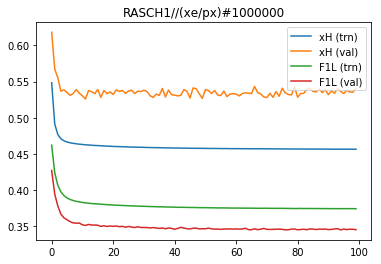

RASCH1//(xe/px)#1000000 None None 		 0.7225628465601508
GO FOR RASCH1//(xe/px)#1000000
checking for cached file ./lfa_models/RASCH1~~(xe~px)#1000000_1
./lfa_models/RASCH1~~(xe~px)#1000000_1 found
class weights: [2.67326092 1.        ]
class weights (dict): {0: 2.6732609156777154, 1: 1.0}
nq, ns
1130 2512
Using univariate Rasch model!
TRAINING:
Unique students: 2512
Unique questions: 1130
Total activity: 658050 ( 478904.0 )
ov shape (658050, 1130) (1254, 1130)
monitoring info loss min
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
hit_counter (InputLayer)        [(None, 1130)]       0                                            

Epoch 12/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4616 - binary_crossentropy: 0.4616 - binary_accuracy: 0.7823 - mean_absolute_error: 0.3027 - mean_squared_error: 0.1503 - f1_loss: 0.3822 - val_loss: 0.5300 - val_binary_crossentropy: 0.5300 - val_binary_accuracy: 0.7368 - val_mean_absolute_error: 0.3402 - val_mean_squared_error: 0.1765 - val_f1_loss: 0.3522
Epoch 13/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4627 - binary_crossentropy: 0.4627 - binary_accuracy: 0.7814 - mean_absolute_error: 0.3032 - mean_squared_error: 0.1507 - f1_loss: 0.3822 - val_loss: 0.5317 - val_binary_crossentropy: 0.5317 - val_binary_accuracy: 0.7352 - val_mean_absolute_error: 0.3383 - val_mean_squared_error: 0.1769 - val_f1_loss: 0.3512
Epoch 14/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4611 - binary_crossentropy: 0.4611 - binary_accuracy: 0.7828 - mean_absolute_error: 0.3017 - mean_squared_error: 0.1500 - f1_loss: 0.3815 - 

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4582 - binary_crossentropy: 0.4582 - binary_accuracy: 0.7842 - mean_absolute_error: 0.2983 - mean_squared_error: 0.1490 - f1_loss: 0.3771 - val_loss: 0.5337 - val_binary_crossentropy: 0.5337 - val_binary_accuracy: 0.7321 - val_mean_absolute_error: 0.3342 - val_mean_squared_error: 0.1764 - val_f1_loss: 0.3476
Epoch 34/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4586 - binary_crossentropy: 0.4586 - binary_accuracy: 0.7836 - mean_absolute_error: 0.2988 - mean_squared_error: 0.1492 - f1_loss: 0.3769 - val_loss: 0.5347 - val_binary_crossentropy: 0.5347 - val_binary_accuracy: 0.7329 - val_mean_absolute_error: 0.3344 - val_mean_squared_error: 0.1765 - val_f1_loss: 0.3479
Epoch 35/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4573 - binary_crossentropy: 0.4573 - binary_accuracy: 0.7846 - mean_absolute_error: 0.2978 - mean_squared_error: 0.1487 - f1_loss: 0.3763 - val_loss: 0.5

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4575 - binary_crossentropy: 0.4575 - binary_accuracy: 0.7844 - mean_absolute_error: 0.2971 - mean_squared_error: 0.1488 - f1_loss: 0.3757 - val_loss: 0.5329 - val_binary_crossentropy: 0.5329 - val_binary_accuracy: 0.7329 - val_mean_absolute_error: 0.3335 - val_mean_squared_error: 0.1754 - val_f1_loss: 0.3464
Epoch 55/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4561 - binary_crossentropy: 0.4561 - binary_accuracy: 0.7854 - mean_absolute_error: 0.2965 - mean_squared_error: 0.1483 - f1_loss: 0.3749 - val_loss: 0.5296 - val_binary_crossentropy: 0.5296 - val_binary_accuracy: 0.7368 - val_mean_absolute_error: 0.3339 - val_mean_squared_error: 0.1747 - val_f1_loss: 0.3462
Epoch 56/100
2057/2057 [==============================] - 9s 3ms/step - loss: 0.4551 - binary_crossentropy: 0.4551 - binary_accuracy: 0.7859 - mean_absolute_error: 0.2958 - mean_squared_error: 0.1479 - f1_loss: 0.3743 - val_loss: 0.5

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4573 - binary_crossentropy: 0.4573 - binary_accuracy: 0.7844 - mean_absolute_error: 0.2968 - mean_squared_error: 0.1487 - f1_loss: 0.3750 - val_loss: 0.5355 - val_binary_crossentropy: 0.5355 - val_binary_accuracy: 0.7337 - val_mean_absolute_error: 0.3327 - val_mean_squared_error: 0.1762 - val_f1_loss: 0.3460
Epoch 76/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4560 - binary_crossentropy: 0.4560 - binary_accuracy: 0.7847 - mean_absolute_error: 0.2962 - mean_squared_error: 0.1484 - f1_loss: 0.3747 - val_loss: 0.5317 - val_binary_crossentropy: 0.5317 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3344 - val_mean_squared_error: 0.1754 - val_f1_loss: 0.3468
Epoch 77/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4560 - binary_crossentropy: 0.4560 - binary_accuracy: 0.7851 - mean_absolute_error: 0.2959 - mean_squared_error: 0.1483 - f1_loss: 0.3741 - val_loss: 0.5

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4567 - binary_crossentropy: 0.4567 - binary_accuracy: 0.7844 - mean_absolute_error: 0.2963 - mean_squared_error: 0.1486 - f1_loss: 0.3744 - val_loss: 0.5316 - val_binary_crossentropy: 0.5316 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3349 - val_mean_squared_error: 0.1752 - val_f1_loss: 0.3468
Epoch 97/100
2057/2057 [==============================] - 10s 4ms/step - loss: 0.4549 - binary_crossentropy: 0.4549 - binary_accuracy: 0.7859 - mean_absolute_error: 0.2952 - mean_squared_error: 0.1478 - f1_loss: 0.3743 - val_loss: 0.5336 - val_binary_crossentropy: 0.5336 - val_binary_accuracy: 0.7392 - val_mean_absolute_error: 0.3334 - val_mean_squared_error: 0.1754 - val_f1_loss: 0.3457
Epoch 98/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4556 - binary_crossentropy: 0.4556 - binary_accuracy: 0.7862 - mean_absolute_error: 0.2956 - mean_squared_error: 0.1481 - f1_loss: 0.3743 - val_loss: 0.

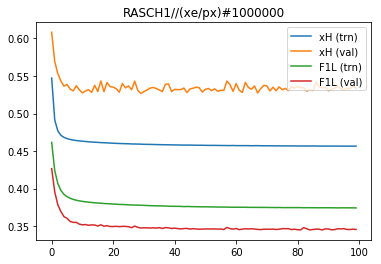

RASCH1//(xe/px)#1000000 None None 		 0.7225628465601508
RASCH1//(xe/px)#1000000 None None 		 0.7230908474427966
GO FOR RASCH1//(xe/px)#1000000
checking for cached file ./lfa_models/RASCH1~~(xe~px)#1000000_2
./lfa_models/RASCH1~~(xe~px)#1000000_2 found
class weights: [2.67326092 1.        ]
class weights (dict): {0: 2.6732609156777154, 1: 1.0}
nq, ns
1130 2512
Using univariate Rasch model!
TRAINING:
Unique students: 2512
Unique questions: 1130
Total activity: 658050 ( 478904.0 )
ov shape (658050, 1130) (1254, 1130)
monitoring info loss min
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
hit_counter (InputLayer)        [(None, 11

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4632 - binary_crossentropy: 0.4632 - binary_accuracy: 0.7806 - mean_absolute_error: 0.3039 - mean_squared_error: 0.1509 - f1_loss: 0.3834 - val_loss: 0.5374 - val_binary_crossentropy: 0.5374 - val_binary_accuracy: 0.7313 - val_mean_absolute_error: 0.3397 - val_mean_squared_error: 0.1789 - val_f1_loss: 0.3535
Epoch 12/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4638 - binary_crossentropy: 0.4638 - binary_accuracy: 0.7807 - mean_absolute_error: 0.3038 - mean_squared_error: 0.1511 - f1_loss: 0.3822 - val_loss: 0.5375 - val_binary_crossentropy: 0.5375 - val_binary_accuracy: 0.7368 - val_mean_absolute_error: 0.3391 - val_mean_squared_error: 0.1788 - val_f1_loss: 0.3529
Epoch 13/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4621 - binary_crossentropy: 0.4621 - binary_accuracy: 0.7820 - mean_absolute_error: 0.3025 - mean_squared_error: 0.1505 - f1_loss: 0.3818 - val_loss: 0.5

2057/2057 [==============================] - 9s 3ms/step - loss: 0.4592 - binary_crossentropy: 0.4592 - binary_accuracy: 0.7834 - mean_absolute_error: 0.2991 - mean_squared_error: 0.1494 - f1_loss: 0.3778 - val_loss: 0.5295 - val_binary_crossentropy: 0.5295 - val_binary_accuracy: 0.7408 - val_mean_absolute_error: 0.3366 - val_mean_squared_error: 0.1751 - val_f1_loss: 0.3481
Epoch 33/100
2057/2057 [==============================] - 9s 3ms/step - loss: 0.4585 - binary_crossentropy: 0.4585 - binary_accuracy: 0.7842 - mean_absolute_error: 0.2985 - mean_squared_error: 0.1491 - f1_loss: 0.3773 - val_loss: 0.5305 - val_binary_crossentropy: 0.5305 - val_binary_accuracy: 0.7408 - val_mean_absolute_error: 0.3351 - val_mean_squared_error: 0.1748 - val_f1_loss: 0.3474
Epoch 34/100
2057/2057 [==============================] - 8s 3ms/step - loss: 0.4577 - binary_crossentropy: 0.4577 - binary_accuracy: 0.7842 - mean_absolute_error: 0.2979 - mean_squared_error: 0.1488 - f1_loss: 0.3767 - val_loss: 0.5

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4569 - binary_crossentropy: 0.4569 - binary_accuracy: 0.7845 - mean_absolute_error: 0.2970 - mean_squared_error: 0.1486 - f1_loss: 0.3749 - val_loss: 0.5327 - val_binary_crossentropy: 0.5327 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3334 - val_mean_squared_error: 0.1752 - val_f1_loss: 0.3462
Epoch 54/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4574 - binary_crossentropy: 0.4574 - binary_accuracy: 0.7843 - mean_absolute_error: 0.2971 - mean_squared_error: 0.1487 - f1_loss: 0.3752 - val_loss: 0.5303 - val_binary_crossentropy: 0.5303 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3331 - val_mean_squared_error: 0.1747 - val_f1_loss: 0.3458
Epoch 55/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4562 - binary_crossentropy: 0.4562 - binary_accuracy: 0.7849 - mean_absolute_error: 0.2965 - mean_squared_error: 0.1484 - f1_loss: 0.3755 - val_loss: 0.5

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4557 - binary_crossentropy: 0.4557 - binary_accuracy: 0.7852 - mean_absolute_error: 0.2959 - mean_squared_error: 0.1482 - f1_loss: 0.3745 - val_loss: 0.5305 - val_binary_crossentropy: 0.5305 - val_binary_accuracy: 0.7352 - val_mean_absolute_error: 0.3338 - val_mean_squared_error: 0.1747 - val_f1_loss: 0.3460
Epoch 75/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4574 - binary_crossentropy: 0.4574 - binary_accuracy: 0.7848 - mean_absolute_error: 0.2966 - mean_squared_error: 0.1487 - f1_loss: 0.3749 - val_loss: 0.5348 - val_binary_crossentropy: 0.5348 - val_binary_accuracy: 0.7337 - val_mean_absolute_error: 0.3323 - val_mean_squared_error: 0.1759 - val_f1_loss: 0.3454
Epoch 76/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4565 - binary_crossentropy: 0.4565 - binary_accuracy: 0.7848 - mean_absolute_error: 0.2964 - mean_squared_error: 0.1485 - f1_loss: 0.3746 - val_loss: 0.5

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4562 - binary_crossentropy: 0.4562 - binary_accuracy: 0.7851 - mean_absolute_error: 0.2961 - mean_squared_error: 0.1484 - f1_loss: 0.3744 - val_loss: 0.5308 - val_binary_crossentropy: 0.5308 - val_binary_accuracy: 0.7376 - val_mean_absolute_error: 0.3324 - val_mean_squared_error: 0.1747 - val_f1_loss: 0.3449
Epoch 96/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4557 - binary_crossentropy: 0.4557 - binary_accuracy: 0.7859 - mean_absolute_error: 0.2958 - mean_squared_error: 0.1482 - f1_loss: 0.3739 - val_loss: 0.5331 - val_binary_crossentropy: 0.5331 - val_binary_accuracy: 0.7376 - val_mean_absolute_error: 0.3346 - val_mean_squared_error: 0.1754 - val_f1_loss: 0.3467
Epoch 97/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4559 - binary_crossentropy: 0.4559 - binary_accuracy: 0.7851 - mean_absolute_error: 0.2960 - mean_squared_error: 0.1483 - f1_loss: 0.3743 - val_loss: 0.5

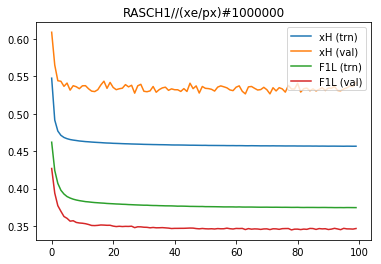

RASCH1//(xe/px)#1000000 None None 		 0.7225628465601508
RASCH1//(xe/px)#1000000 None None 		 0.7230908474427966
RASCH1//(xe/px)#1000000 None None 		 0.7240811485037297
GO FOR RASCH1//(xe/px)#1000000
checking for cached file ./lfa_models/RASCH1~~(xe~px)#1000000_3
./lfa_models/RASCH1~~(xe~px)#1000000_3 found
class weights: [2.67326092 1.        ]
class weights (dict): {0: 2.6732609156777154, 1: 1.0}
nq, ns
1130 2512
Using univariate Rasch model!
TRAINING:
Unique students: 2512
Unique questions: 1130
Total activity: 658050 ( 478904.0 )
ov shape (658050, 1130) (1254, 1130)
monitoring info loss min
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4622 - binary_crossentropy: 0.4622 - binary_accuracy: 0.7823 - mean_absolute_error: 0.3033 - mean_squared_error: 0.1504 - f1_loss: 0.3831 - val_loss: 0.5317 - val_binary_crossentropy: 0.5317 - val_binary_accuracy: 0.7368 - val_mean_absolute_error: 0.3416 - val_mean_squared_error: 0.1775 - val_f1_loss: 0.3542
Epoch 12/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4627 - binary_crossentropy: 0.4627 - binary_accuracy: 0.7817 - mean_absolute_error: 0.3032 - mean_squared_error: 0.1506 - f1_loss: 0.3823 - val_loss: 0.5326 - val_binary_crossentropy: 0.5326 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3424 - val_mean_squared_error: 0.1777 - val_f1_loss: 0.3547
Epoch 13/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4622 - binary_crossentropy: 0.4622 - binary_accuracy: 0.7815 - mean_absolute_error: 0.3028 - mean_squared_error: 0.1506 - f1_loss: 0.3816 - val_loss: 0.5

2057/2057 [==============================] - 10s 4ms/step - loss: 0.4592 - binary_crossentropy: 0.4592 - binary_accuracy: 0.7837 - mean_absolute_error: 0.2989 - mean_squared_error: 0.1494 - f1_loss: 0.3781 - val_loss: 0.5331 - val_binary_crossentropy: 0.5331 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3377 - val_mean_squared_error: 0.1766 - val_f1_loss: 0.3502
Epoch 33/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4588 - binary_crossentropy: 0.4588 - binary_accuracy: 0.7838 - mean_absolute_error: 0.2989 - mean_squared_error: 0.1492 - f1_loss: 0.3776 - val_loss: 0.5419 - val_binary_crossentropy: 0.5419 - val_binary_accuracy: 0.7265 - val_mean_absolute_error: 0.3371 - val_mean_squared_error: 0.1795 - val_f1_loss: 0.3511
Epoch 34/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4600 - binary_crossentropy: 0.4600 - binary_accuracy: 0.7833 - mean_absolute_error: 0.2993 - mean_squared_error: 0.1497 - f1_loss: 0.3780 - val_loss: 0.

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4577 - binary_crossentropy: 0.4577 - binary_accuracy: 0.7845 - mean_absolute_error: 0.2976 - mean_squared_error: 0.1489 - f1_loss: 0.3760 - val_loss: 0.5342 - val_binary_crossentropy: 0.5342 - val_binary_accuracy: 0.7313 - val_mean_absolute_error: 0.3346 - val_mean_squared_error: 0.1765 - val_f1_loss: 0.3479
Epoch 54/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4563 - binary_crossentropy: 0.4563 - binary_accuracy: 0.7855 - mean_absolute_error: 0.2965 - mean_squared_error: 0.1483 - f1_loss: 0.3755 - val_loss: 0.5340 - val_binary_crossentropy: 0.5340 - val_binary_accuracy: 0.7344 - val_mean_absolute_error: 0.3359 - val_mean_squared_error: 0.1765 - val_f1_loss: 0.3486
Epoch 55/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4582 - binary_crossentropy: 0.4582 - binary_accuracy: 0.7837 - mean_absolute_error: 0.2976 - mean_squared_error: 0.1491 - f1_loss: 0.3761 - val_loss: 0.5

2057/2057 [==============================] - 10s 4ms/step - loss: 0.4559 - binary_crossentropy: 0.4559 - binary_accuracy: 0.7845 - mean_absolute_error: 0.2960 - mean_squared_error: 0.1483 - f1_loss: 0.3747 - val_loss: 0.5337 - val_binary_crossentropy: 0.5337 - val_binary_accuracy: 0.7352 - val_mean_absolute_error: 0.3341 - val_mean_squared_error: 0.1759 - val_f1_loss: 0.3469
Epoch 75/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4564 - binary_crossentropy: 0.4564 - binary_accuracy: 0.7850 - mean_absolute_error: 0.2964 - mean_squared_error: 0.1484 - f1_loss: 0.3748 - val_loss: 0.5343 - val_binary_crossentropy: 0.5343 - val_binary_accuracy: 0.7352 - val_mean_absolute_error: 0.3361 - val_mean_squared_error: 0.1763 - val_f1_loss: 0.3484
Epoch 76/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4559 - binary_crossentropy: 0.4559 - binary_accuracy: 0.7849 - mean_absolute_error: 0.2963 - mean_squared_error: 0.1483 - f1_loss: 0.3742 - val_loss: 0.

2057/2057 [==============================] - 9s 4ms/step - loss: 0.4562 - binary_crossentropy: 0.4562 - binary_accuracy: 0.7844 - mean_absolute_error: 0.2961 - mean_squared_error: 0.1485 - f1_loss: 0.3742 - val_loss: 0.5350 - val_binary_crossentropy: 0.5350 - val_binary_accuracy: 0.7384 - val_mean_absolute_error: 0.3353 - val_mean_squared_error: 0.1765 - val_f1_loss: 0.3477
Epoch 96/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4564 - binary_crossentropy: 0.4564 - binary_accuracy: 0.7846 - mean_absolute_error: 0.2961 - mean_squared_error: 0.1484 - f1_loss: 0.3738 - val_loss: 0.5352 - val_binary_crossentropy: 0.5352 - val_binary_accuracy: 0.7337 - val_mean_absolute_error: 0.3347 - val_mean_squared_error: 0.1765 - val_f1_loss: 0.3475
Epoch 97/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4560 - binary_crossentropy: 0.4560 - binary_accuracy: 0.7853 - mean_absolute_error: 0.2958 - mean_squared_error: 0.1483 - f1_loss: 0.3741 - val_loss: 0.5

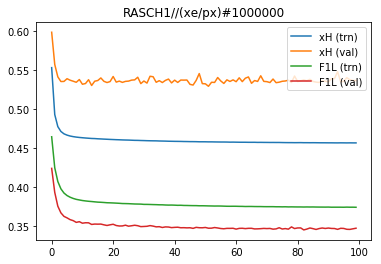

RASCH1//(xe/px)#1000000 None None 		 0.7225628465601508
RASCH1//(xe/px)#1000000 None None 		 0.7230908474427966
RASCH1//(xe/px)#1000000 None None 		 0.7240811485037297
RASCH1//(xe/px)#1000000 None None 		 0.7253275109170306
GO FOR RASCH1//(xe/px)#1000000
checking for cached file ./lfa_models/RASCH1~~(xe~px)#1000000_4
./lfa_models/RASCH1~~(xe~px)#1000000_4 found
class weights: [2.67326092 1.        ]
class weights (dict): {0: 2.6732609156777154, 1: 1.0}
nq, ns
1130 2512
Using univariate Rasch model!
TRAINING:
Unique students: 2512
Unique questions: 1130
Total activity: 658050 ( 478904.0 )
ov shape (658050, 1130) (1254, 1130)
monitoring info loss min
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         [(None, 1)]          0                                            
____________________________

2057/2057 [==============================] - 9s 3ms/step - loss: 0.4631 - binary_crossentropy: 0.4631 - binary_accuracy: 0.7808 - mean_absolute_error: 0.3040 - mean_squared_error: 0.1509 - f1_loss: 0.3828 - val_loss: 0.5310 - val_binary_crossentropy: 0.5310 - val_binary_accuracy: 0.7344 - val_mean_absolute_error: 0.3404 - val_mean_squared_error: 0.1769 - val_f1_loss: 0.3528
Epoch 12/100
2057/2057 [==============================] - 9s 4ms/step - loss: 0.4620 - binary_crossentropy: 0.4620 - binary_accuracy: 0.7820 - mean_absolute_error: 0.3030 - mean_squared_error: 0.1504 - f1_loss: 0.3822 - val_loss: 0.5330 - val_binary_crossentropy: 0.5330 - val_binary_accuracy: 0.7360 - val_mean_absolute_error: 0.3406 - val_mean_squared_error: 0.1777 - val_f1_loss: 0.3530
Epoch 13/100
2057/2057 [==============================] - 9s 3ms/step - loss: 0.4617 - binary_crossentropy: 0.4617 - binary_accuracy: 0.7821 - mean_absolute_error: 0.3024 - mean_squared_error: 0.1503 - f1_loss: 0.3817 - val_loss: 0.5

 936/2057 [============>.................] - ETA: 4s - loss: 0.4591 - binary_crossentropy: 0.4591 - binary_accuracy: 0.7828 - mean_absolute_error: 0.2991 - mean_squared_error: 0.1494 - f1_loss: 0.3770

In [ ]:
#RESET
model_lookup = {} #defaultdict(list)
max_acc = 0
handles = []

from keras.metrics import binary_accuracy, binary_crossentropy, mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score
import os
mon_lookup = {
    "binary_crossentropy" : "xe",
    "mean_squared_error"  : "mse",
    "mean_absolute_error" : "mae",
    "f1_loss" : "f1",
    "binary_accuracy" : "acc",
    "log_likelihood" : "ll",
    "loss" : "px"
}

# max_s = 250000
print("max_s", max_s)


def step_through_cog_models(data_bundle=None, cog_models=None):
# def step_through_cog_models(sixs, qixs, hout, cog_models=None, data_bundle=None):
#     cog_models = ["MLP", "MLP+","MLTM","LFA","SLFA"]
#     cog_models = ["MLP", "MLP+","MLTM", "MLTM+", "MLTM_no_init"]
#     cog_models = ["MLP", "MLP+","MLTM", "MLTM+", "LFA","SLFA"]
    #("MLTM+",32,10,"val_f1_m",False)
    metrics = [binary_crossentropy, binary_accuracy, mean_absolute_error, mean_squared_error, f1_loss]

    if cog_models is None:
        core_models = ["CFM", "RASCH", "AFM", "MLTM"]
        variant_models = ["AFMg", "MLTMb", "MLTM0"]
#         ffnn_models = ["MLPs", "MLPsz"] #"MLP", "MLPd"]#, "CONC"]
        ffnn_models = ["MLPs", "MLP", "MLPd"]#, "CONC"]
        regd_models = [s+"z" for s in ["MLTM","MLP","MLPd","AFM","AFMg","CFM","MLTMb","MLTM0"]]
#         cog_models = variant_models
        cog_models = regd_models
#         cog_models = ["AFM", "AFMg", "AFMx", "MLTM", "MLTMa","MLTMb", "CFM", "MLP", "MLPd"]
#         cog_models = ["MLTMz"] #"MLTMb", "MLP", "CFM", "RASCH", "AFM", "AFMg", "AFMx", "MLTM", "MLTMa","MLTMb","MLTM0", "MLP", "MLPd"]
#         cog_models = ["AFMg"]
#         cog_models = ["MLTMz"]#,"AFMg"]
        cog_models = ["RASCH"]
#         cog_models = ["MLTMb","MLTMbz","MLTM0","MLTM0z"]
#         cog_models = ["MLPrawDen", "MLPrawDP"]#, "MLPrawAD", "MLPrawADD"]
#         cog_models = ffnn_models
#         emb_ws = [400,300,256,128,64,32,16, 8]
        emb_ws = [ 64, ]#, 32, 64]
#         emb_ws = [24, 32]
#         emb_ws = [32, 64, 128]
#         emb_ws = [96]# 32, 64, 96]
#         emb_ws = [8,16,32, 64,128]#, 256, 300, 400]
#         emb_ws = [32,64,128,256,300,400,500]

#         emb_ws = [8,]#, 16, 32, 64, 128, 256, 300, 400,]

#         q_ws = [None]
#         losses = ["binary_crossentropy","mean_squared_error","f1_loss"]#, "binary_crossentropy"]
#         losses = [("binary_crossentropy", "val_loss")]
        losses = [
                    ("binary_crossentropy", "val_loss"), 
#                   ("binary_crossentropy", "val_f1_loss"), 
#                   ("mean_squared_error", "val_loss"),
#                   ("f1_loss", "val_f1_loss")
                 ]
#         losses = [("f1_loss", "val_f1_loss")]
        q_ws = [None]

#         reg_ws = numpy.random.normal(loc=1e-5, scale=1e-5, size=20) # [1e-8, 1e-7, 1e-6, 0.00001]#, 0.0001, 0.001]
        reg_ws = [None]
#         reg_ws = [None, 0.001, 0.0001, 0.00001]

#         monitor_settings = ["val_mean_absolute_error", "val_mean_squared_error"]
#         monitor_settings = ["val_loss", "val_f1_m", "val_mean_squared_error"]
        balance_settings = [ False, ]
#         q_ws = [None, 1, 5, 10, 50, 100, 500]
#         q_ws = [None,1,10,100,1000]
#     emb_ws = [14, ]# [1,2,4,6,8,10,12,14,16]
#     emb_ws = [1,2,4,6,8,10,12,14,16]
    n_reps = 5

    payload = []
        

    seen=[]
    
    
    odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = data_bundle
    (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
    o_hits = o_hits.astype("int8")
    
    print(len(v_out), sum(v_out))
    print(len(t_out), sum(t_out))
#     raise Exception("le what")
    
    f1s = []
    overwrite_disc=True
    for rep in range(n_reps):
        for cog_model in cog_models:# zip(cog_models, q_ws):
            for w in emb_ws:
                if cog_model=="RASCH":
                    w=1
                for qw in q_ws:
                    for rw in reg_ws:
                        w0 = rw
                        for bal in balance_settings:
                            for lozz,mon in losses:
                                best_f1_regw = (0,0)
#                                 rw = None #rw / (w*n_students)
                                #w1 = rw if (rw is not None) else None
#                                 w1 = 5.5e-8
                                w1 = rw
    
#                                 if max_w = None:
#                                     max_w = (rw, 0)                
#                                 w1s = numpy.random.normal(max_w[0], scale=w1, size=10)
                    
                                qcode = "" if (qw is None) else "q"+str(qw)
                                moncode = mon_lookup[mon[mon.index("_")+1:]]
                                losscode = mon_lookup[lozz]
                                balstr = "bal" if bal else ""
                                
                                handle = "{}{}/{}/{}({}/{})".format(cog_model, w, qcode, balstr, losscode, moncode)
                                memkey = handle+str(w1)
                                if max_s != 100000:
                                    handle += "#"+str(max_s)
                                print("GO FOR", handle)
                                
                                fn = home+"/lfa_models/" + handle.replace("/","~") + "_" + str(rep)
                                
                                print("checking for cached file", fn)
                                if os.path.isfile(fn):
                                    print(fn, "found")
#                                     continue         
                                
                                m, h, config_dict = gen_and_train(odata, vdata, tdata, draw=True, cog_model=cog_model, emb_w=w, q_weight=qw, monitor=mon, balance_classes=bal, loss=lozz, metrics=metrics, reg_w=w1)
#                                 m.summary()
#                                 t_sixs, t_qixs, t_hits, _ = t_data
#                                 o_sixs, o_qixs, o_hits, _ = o_data

                                op_hats = numpy.round( m.predict( [o_qixs, o_sixs, o_hits] ) )
                                op_trues = numpy.round(o_out)    
                                o_f1 = f1_score(op_trues, op_hats, average="macro")

                                vp_hats = numpy.round( m.predict( [v_qixs, v_sixs, v_hits] ) )
                                vp_trues = numpy.round(v_out)    
                                v_f1 = f1_score(vp_trues, vp_hats, average="macro")
    
                                p_hats = numpy.round( m.predict( [t_qixs, t_sixs, t_hits] ) )
                                p_trues = numpy.round(t_out)    
                                t_f1 = f1_score(p_trues, p_hats, average="macro")
                
#                                 if t_f1 > max_w[1]:
#                                     max_w = (w1,t_f1)
                
                                print(w1, ":F1s v/t ", o_f1, v_f1, t_f1)
                                f1s.append((handle, w0, w1, v_f1, t_f1))
                
                                config_dict["q_weight"]=qw
                                config_dict["monitor_value"]=mon
                                config_dict["balance_classes"]=bal
                                config_dict["loss"]=lozz
                                
                                config_dict["handle"] = handle
                                
                                payload.append( (config_dict, _, _) )
                                
                                plt.plot(h.history['loss'], label='xH (trn)')
                                plt.plot(h.history['val_loss'], label='xH (val)')
                                plt.plot(h.history['f1_loss'], label='F1L (trn)')
                                plt.plot(h.history['val_f1_loss'], label='F1L (val)')
                                plt.title(handle)
#                                 plt.ylabel('MAE value')
#                                 plt.xlabel('No. epoch')
                                plt.legend(loc="upper right")
                                plt.show()
                                
                                if overwrite_disc:
                                    try:
                                        m.save(home+"/lfa_models/" + handle.replace("/","~") + "_" + str(rep), save_format="h5")
                                    except OSError as ose:
                                        print(ose)
                                        import shutil
                                        shutil.rmtree(fn)
                                        m.save(home+"/lfa_models/" + handle.replace("/","~") + "_" + str(rep), save_format="h5")
                                                                
        for h, ww,w,v,t in f1s:
    #         print(h, ww,w,"\t", v,"\t", t)
            print(h, ww,w,"\t\t", t)

    mn = numpy.median([tup[4] for tup in f1s])
    mae = numpy.mean([numpy.abs(tup[4]-mn) for tup in f1s])
    print(mn, mae)
    
    return payload, data_bundle

#########################################

# try:
#     del data_bundle
# except:
#     pass

# try:
#     data_bundle
#     print("DATA FOUJND")
#     (sixs, qixs, hout) = (None, None, None)
# except:
#     data_bundle = None
# (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
    

history_results, data_bundle = step_through_cog_models(data_bundle=data_bundle)
(o_data, v_data, t_data, sid_six_lookup, qid_qix_lookup) = data_bundle

(o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (o_data, v_data, t_data)
print(numpy.array(o_hits).shape)
print(numpy.array(v_hits).shape)
print(numpy.array(t_hits).shape)

print("DATAGEN DONE")
print(max(o_qixs), max(v_qixs))

In [ ]:
# f1_kde={}
# acc_kde={}
# upto=10
# for h in seen:
#     print(h)
#     pears = numpy.array(agg[h])
#     f1s = [p[0] for p in pears]
#     mu_f1 = numpy.mean(f1s)
#     accs = [p[1] for p in pears]
#     mu_acc = numpy.mean(accs)
#     print(h, len(pears))
#     print(pears)
# #     print(av_f1, av_acc)
#     print("\t", numpy.round(mu_f1,4), numpy.round(mu_acc,4))
#     f1_kde[h] = f1s[0:upto]
#     acc_kde[h] = accs[0:upto]

# print("Plot of resultant F1 score")
# # print(f1_kde)
# for row in f1_kde:
#     print(row)
# ax1 = pandas.DataFrame(f1_kde).plot.kde(bw_method=.8, figsize=(8,8))
# ax1.set_xlabel("$F_{1}$")
# ax1.set_title("Distribution of prediction $F_{1}$ across models")

# print("Plot of resultant F1 score")
# print(acc_kde)
# ax2 = pandas.DataFrame(acc_kde).plot.kde(bw_method=.8, figsize=(8,8))
# ax2.set_xlabel("Accuracy")
# ax2.set_title("Distribution of prediction accuracy across models")

# plt.show()